- MLP
- Multiple countries
- Trained on the whole sequence, not autoregressive

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

In [69]:
# Load the CSV file
path = "data/COVID_data.csv"
df = pd.read_csv(path)  # Replace with your file path

country_waves = {"Republic of Korea": {1: [15, 123],
                                   2: [206, 295],
                                   3: [289, 436],
                                   4: [533, 652], #좀 애매함
                                   5: [736, 897],
                                   6: [897, 1010],
                                   7: [1010, 1164] #wave가 애매하게 2개임
                                   },
            "China": {1: [0, 74],
                      2: [66, 119],
                      3: [154, 266],
                      4: [316, 413], #wave가 살짝 2개에 가까움
                      5: [484, 561],
                      6: [1065, 1119],
                      },
            "United Kingdom of Great Britain and Northern Ireland": {1: [52, 184],
                                                                     2: [192, 486], #wave가 2개라서 아래의 3,4번에서 2개로 나눠도 봄.
                                                                     3: [192, 330], #2번의 앞쪽 wave
                                                                     4: [331, 486], #2번의 뒤쪽 wave
                                                                     5: [772, 871],
                                                                     6: [869, 983]
                   }
            }

using_coutries = ["Republic of Korea", "China", "United Kingdom of Great Britain and Northern Ireland"]
kind = 'New_cases' #[New_cases, Cumulative_cases, New_deaths, Cumulative_deaths]

time_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}
wave_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}

for country in using_coutries:
    country_data = df[df["Country"] == country]
    country_data["Date_reported"] = pd.to_datetime(country_data["Date_reported"])
    country_data["Date_reported"] = (country_data["Date_reported"] - country_data["Date_reported"].iloc[0]).dt.days
    new_cases = country_data[kind].values
    new_cases[new_cases < 1] = 1

    for wave in country_waves[country]:
        start, end = country_waves[country][wave]
        time_data[country][wave] = country_data["Date_reported"].values[start:end]
        wave_data[country][wave] = new_cases[start:end]

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\247199454.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Date_reported"] = pd.to_datetime(country_data["Date_reported"])
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\247199454.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Date_reported"] = (country_data["Date_reported"] - country_data["Date_reported"].iloc[0]).dt.days
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\247199454.py:37: SettingWithCopyWarni

In [63]:
# Define a function to calculate the 7-number moving average
def moving_average(data, window_size=7):
    half_window = window_size // 2
    smoothed = []
    
    for i in range(len(data)):
        # Handle edge cases
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)
        
        # Calculate the average of the current window
        smoothed.append(np.mean(data[start:end]))
    
    return smoothed

data = {} # smoothed data

for country in wave_data:
    data[country] = {}
    for wave in wave_data[country]:
        data[country][wave] = moving_average(wave_data[country][wave])

# which countries, which waves to use for training
training_coutries = ["Republic of Korea", "China"]
test_coutries = ["United Kingdom of Great Britain and Northern Ireland"]

# Model

In [75]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t):
        return self.model(t)

# Defining the loss functions
def MSE_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

def SIR_loss(model, t, beta, gamma, mu):
    t = t.requires_grad_(True)  # Enable gradient computation for time tensor

    # Forward pass through the model
    x = model(t)

    # Compute gradients
    dx_dt = torch.autograd.grad(
        x, t, grad_outputs=torch.ones_like(x), create_graph=True
    )[0]  # First derivative

    # SIR model loss: dI/dt = beta * I - gamma * I
    sir_loss = dx_dt + beta * torch.exp(x) - gamma * torch.exp(x)

    # Return the squared loss
    return torch.mean(sir_loss ** 2)

In [82]:
def plot_predictions(t_data, y_data, t_predict, predicted_values, date_ticks, country, epoch):
    """
    Plot predictions and training results.
    """
    # Ensure the save directory exists
    #if not os.path.exists(save_path):
    #    os.makedirs(save_path)

    fig, ax1 = plt.subplots(figsize=(18, 8))
    plt.title(f"{country}. Epoch: {epoch + 1}")

    # Training Data
    ax1.plot(t_data, y_data, 'ro', markersize=8, label='Training data')

    # Predicted values
    ax1.plot(t_predict, predicted_values, color="orange", label="Predicted by PINN")

    # Format x-axis
    ax1.set_xlabel("Date")
    ax1.set_ylabel("I(t)", color="k")
    ax1.tick_params(axis='y', labelcolor="k")
    ax1.legend(loc="upper left")
    ax1.grid()

    # Set date ticks
    tick_labels = date_ticks[:len(t_data[::7])]
    ax1.set_xticks(t_data[::7].flatten())
    ax1.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor")

    # Plotting
    plt.tight_layout()
    plt.show()
    plt.close()

In [68]:
class EarlyStopping:
    def __init__(self, model, patience, display_step, sigma, sigma0, mu):
        self.patience = patience
        self.display_step = display_step
        self.model = model
        self.sigma = sigma
        self.sigma0 = sigma0
        self.mu = mu
        
        self.best_loss = np.inf
        self.wait = 0

        self.best_model = None
        self.bests_weights = None
        self.bestSigma = None
        self.bestSigma0 = None
        self.bestMu = None

    def check_early_stopping(self, current_loss, epoch):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0

            self.best_model = self.model
            self.best_weights = self.model.state_dict()
            self.bestSigma = self.sigma
            self.bestSigma0 = self.sigma0
            self.bestMu = self.mu
        else:
            self.wait += 1
        
        if self.wait >= self.patience:
            print(f"Early stopping at epoch {epoch}.")
            self.model.load_state_dict(self.best_weights)
            return True
        return False

In [86]:
# Training loop
def train(model, optimizer, t_data, y_data, t_train, y_train, sigma, sigma0, mu, epochs, patience, display_step, date_ticks, country):
    early_stopping = EarlyStopping(model, patience, display_step, sigma, sigma0, mu)
    losses = []

    for epoch in range(epochs):
        model.train()
        t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
        y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()

        y_pred = model(t_tensor)
        mse_loss = MSE_loss(y_tensor, y_pred)
        sir_loss = SIR_loss(model, t_tensor, sigma, sigma0, mu)

        total_loss = mse_loss + sir_loss

        total_loss.backward()
        optimizer.step()

        losses.append(total_loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}, MSE Loss = {mse_loss.item()}, SIR Loss = {sir_loss.item()}, Total Loss = {total_loss.item()}")
        
        if epoch % display_step == 0:
            with torch.no_grad():
                predicted_values = model(t_data).detach().numpy()
                plot_predictions(
                    t_data=t_data.detach().numpy(),
                    y_data=y_train.detach().numpy(),
                    t_predict=t_data.detach().numpy(),
                    predicted_values=predicted_values,
                    date_ticks=date_ticks,
                    country=country,
                    epoch=epoch,
                )

        if early_stopping.check_early_stopping(total_loss.item(), epoch):
            break
    
    return losses

# Initialize parameters
sigma = torch.tensor([0.1], requires_grad=True)
sigma0 = torch.tensor([0.1], requires_grad=True)
mu = torch.tensor([0.1], requires_grad=True)

# Traninig

Epoch 1, MSE Loss = 0.06424309313297272, SIR Loss = 7.58954588064853e-09, Total Loss = 0.06424310058355331


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


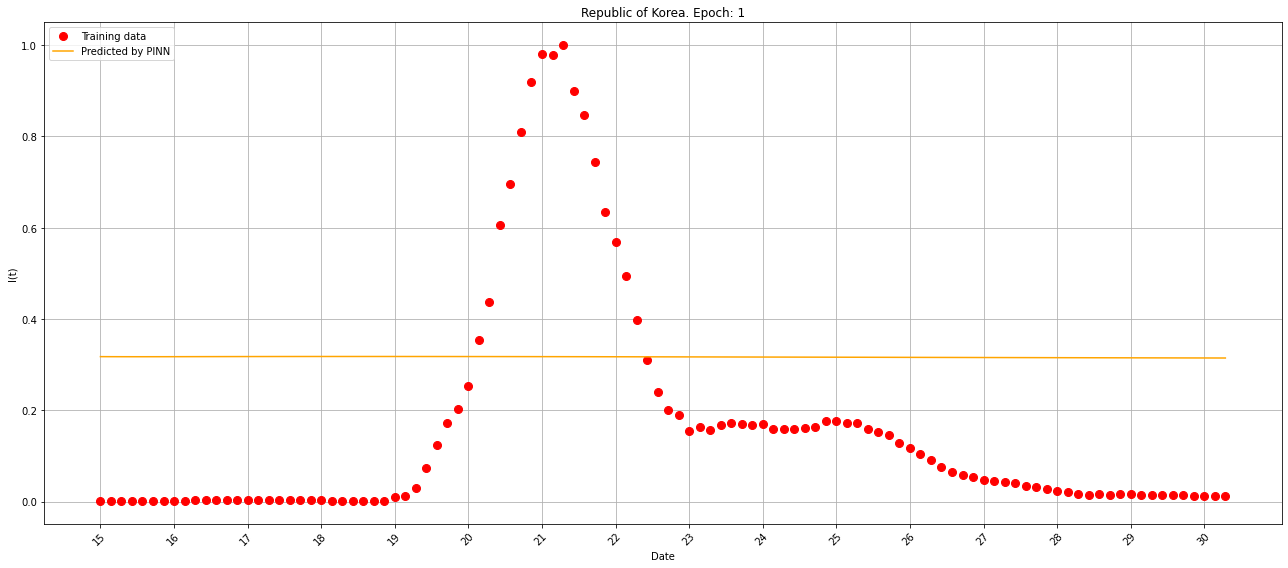

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.055022697895765305, SIR Loss = 2.1765219571534544e-05, Total Loss = 0.05504446476697922
Epoch 201, MSE Loss = 0.04098275303840637, SIR Loss = 6.143102655187249e-05, Total Loss = 0.04104418307542801
Epoch 301, MSE Loss = 0.03476303443312645, SIR Loss = 0.00014249654486775398, Total Loss = 0.034905530512332916
Epoch 401, MSE Loss = 0.035731758922338486, SIR Loss = 0.00011057897063437849, Total Loss = 0.03584233671426773
Epoch 501, MSE Loss = 0.08485029637813568, SIR Loss = 0.00011439727677498013, Total Loss = 0.08496469259262085
Epoch 601, MSE Loss = 0.03330386430025101, SIR Loss = 0.00016866737860254943, Total Loss = 0.03347253054380417
Epoch 701, MSE Loss = 0.03353584185242653, SIR Loss = 0.00010716858378145844, Total Loss = 0.03364301100373268
Epoch 801, MSE Loss = 0.035743389278650284, SIR Loss = 6.406797911040485e-05, Total Loss = 0.03580745682120323
Epoch 901, MSE Loss = 0.03190626949071884, SIR Loss = 0.00014000741066411138, Total Loss = 0.03204627707600593

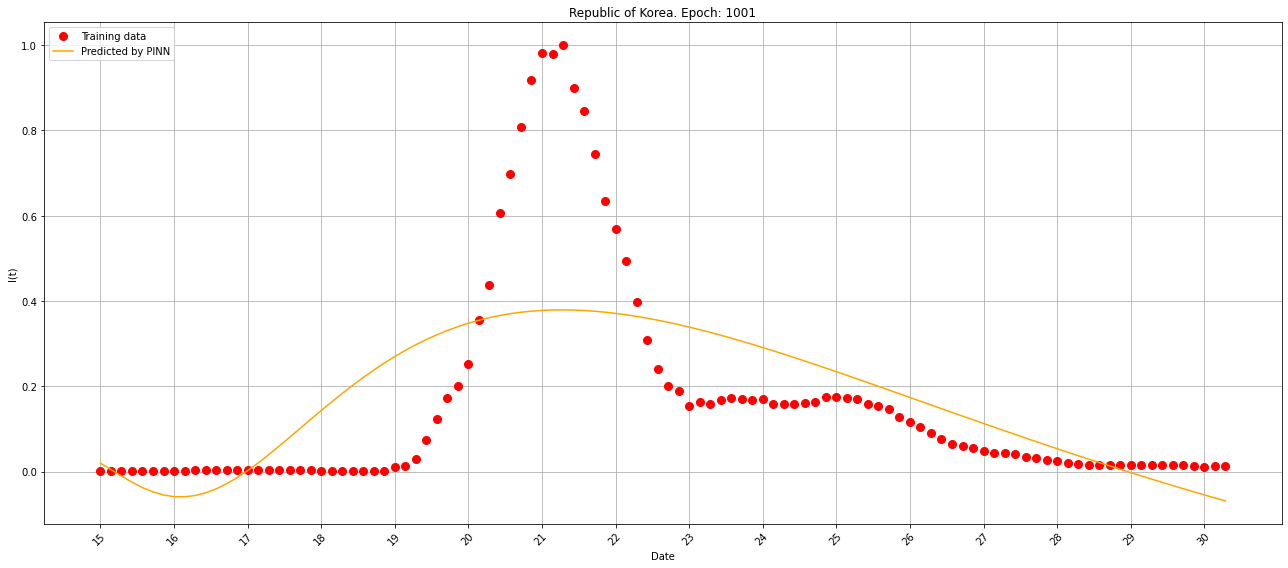

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.031461212784051895, SIR Loss = 0.00013678104733116925, Total Loss = 0.03159799426794052
Epoch 1201, MSE Loss = 0.038606446236371994, SIR Loss = 5.9712649090215564e-05, Total Loss = 0.03866615891456604
Epoch 1301, MSE Loss = 0.03195863217115402, SIR Loss = 0.0001533511240268126, Total Loss = 0.03211198374629021
Epoch 1401, MSE Loss = 0.03078979253768921, SIR Loss = 0.0001375756983179599, Total Loss = 0.030927367508411407
Epoch 1501, MSE Loss = 0.03484335169196129, SIR Loss = 8.342418004758656e-05, Total Loss = 0.034926775842905045
Epoch 1601, MSE Loss = 0.03124963864684105, SIR Loss = 0.00014481034304481, Total Loss = 0.03139444813132286
Epoch 1701, MSE Loss = 0.030042491853237152, SIR Loss = 0.00014271397958509624, Total Loss = 0.03018520586192608
Epoch 1801, MSE Loss = 0.03209436684846878, SIR Loss = 0.00012620769848581403, Total Loss = 0.03222057595849037
Epoch 1901, MSE Loss = 0.030542846769094467, SIR Loss = 0.00014023792755324394, Total Loss = 0.0306830853

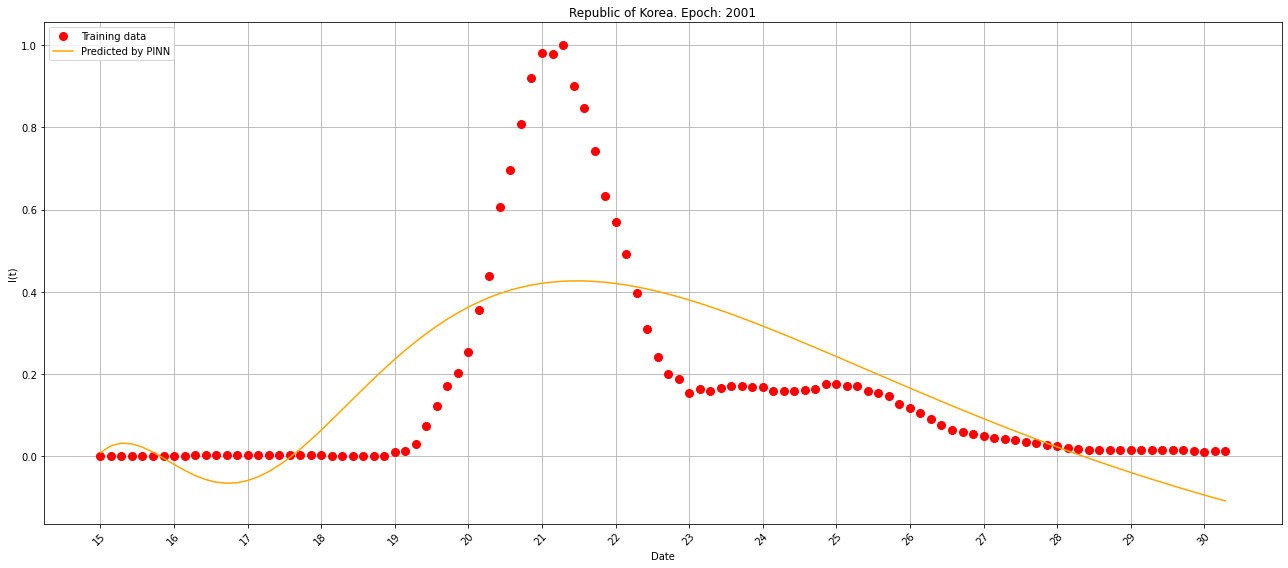

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 2101, MSE Loss = 0.03325697034597397, SIR Loss = 9.8646771220956e-05, Total Loss = 0.03335561603307724
Epoch 2201, MSE Loss = 0.030743690207600594, SIR Loss = 0.0001434229052392766, Total Loss = 0.030887113884091377
Epoch 2301, MSE Loss = 0.02960195206105709, SIR Loss = 0.00014996402023825794, Total Loss = 0.029751915484666824
Epoch 2401, MSE Loss = 0.032612595707178116, SIR Loss = 9.972551197279245e-05, Total Loss = 0.03271232172846794
Epoch 2501, MSE Loss = 0.030200524255633354, SIR Loss = 0.00014426198322325945, Total Loss = 0.030344786122441292
Epoch 2601, MSE Loss = 0.02916669473052025, SIR Loss = 0.0001589781022630632, Total Loss = 0.02932567335665226
Epoch 2701, MSE Loss = 0.03857443109154701, SIR Loss = 5.5397191317752004e-05, Total Loss = 0.03862982988357544
Epoch 2801, MSE Loss = 0.03083239309489727, SIR Loss = 0.0001499889331171289, Total Loss = 0.030982382595539093
Epoch 2901, MSE Loss = 0.029692018404603004, SIR Loss = 0.00014887560973875225, Total Loss = 0.029840894

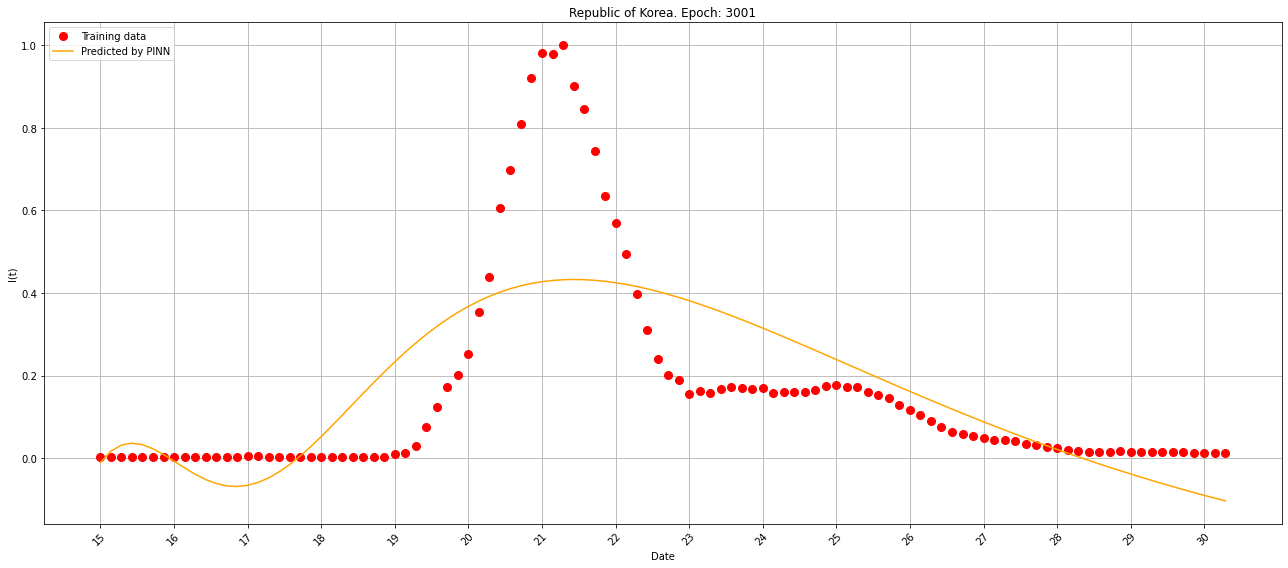

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 3101, MSE Loss = 0.03216603025794029, SIR Loss = 0.00010599714005365968, Total Loss = 0.03227202594280243
Epoch 3201, MSE Loss = 0.02998458594083786, SIR Loss = 0.00014769908739253879, Total Loss = 0.03013228438794613
Epoch 3301, MSE Loss = 0.02895725704729557, SIR Loss = 0.000164075376233086, Total Loss = 0.029121331870555878
Epoch 3401, MSE Loss = 0.052743371576070786, SIR Loss = 0.00019777333363890648, Total Loss = 0.05294114351272583
Epoch 3501, MSE Loss = 0.030860329046845436, SIR Loss = 0.0001424722868250683, Total Loss = 0.031002800911664963
Epoch 3601, MSE Loss = 0.029550494626164436, SIR Loss = 0.00015157015877775848, Total Loss = 0.029702065512537956
Epoch 3701, MSE Loss = 0.028582444414496422, SIR Loss = 0.00017203435709234327, Total Loss = 0.028754478320479393
Epoch 3801, MSE Loss = 0.037739939987659454, SIR Loss = 7.619024836458266e-05, Total Loss = 0.0378161296248436
Epoch 3901, MSE Loss = 0.03057274967432022, SIR Loss = 0.0001465013629058376, Total Loss = 0.0307192

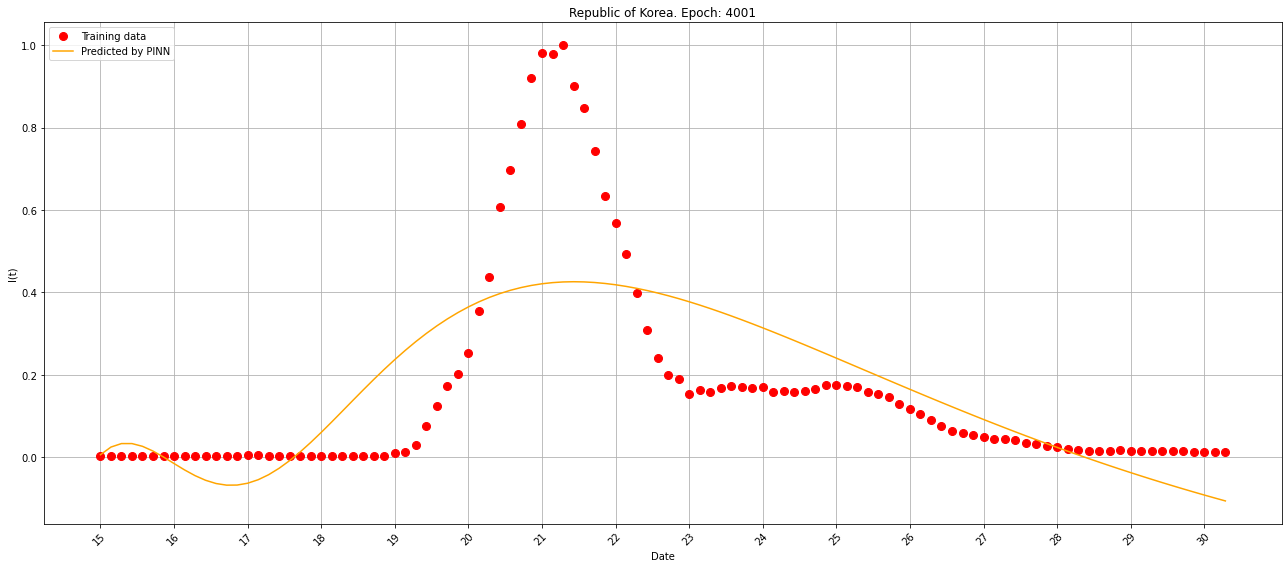

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 4101, MSE Loss = 0.028377758339047432, SIR Loss = 0.000177511727088131, Total Loss = 0.02855527028441429
Epoch 4201, MSE Loss = 0.11725606769323349, SIR Loss = 0.0001600473769940436, Total Loss = 0.11741611361503601
Epoch 4301, MSE Loss = 0.02950478531420231, SIR Loss = 0.0001561745157232508, Total Loss = 0.029660960659384727
Epoch 4401, MSE Loss = 0.02850157767534256, SIR Loss = 0.00017172332445625216, Total Loss = 0.02867330051958561
Epoch 4501, MSE Loss = 0.027730166912078857, SIR Loss = 0.0001982344256248325, Total Loss = 0.02792840078473091
Epoch 4601, MSE Loss = 0.033721473067998886, SIR Loss = 8.740355406189337e-05, Total Loss = 0.0338088758289814
Epoch 4701, MSE Loss = 0.02894558012485504, SIR Loss = 0.0001567218278069049, Total Loss = 0.029102301225066185
Epoch 4801, MSE Loss = 0.0280620064586401, SIR Loss = 0.00017679792654234916, Total Loss = 0.028238805010914803
Epoch 4901, MSE Loss = 0.027355285361409187, SIR Loss = 0.0002012137701967731, Total Loss = 0.0275564994663

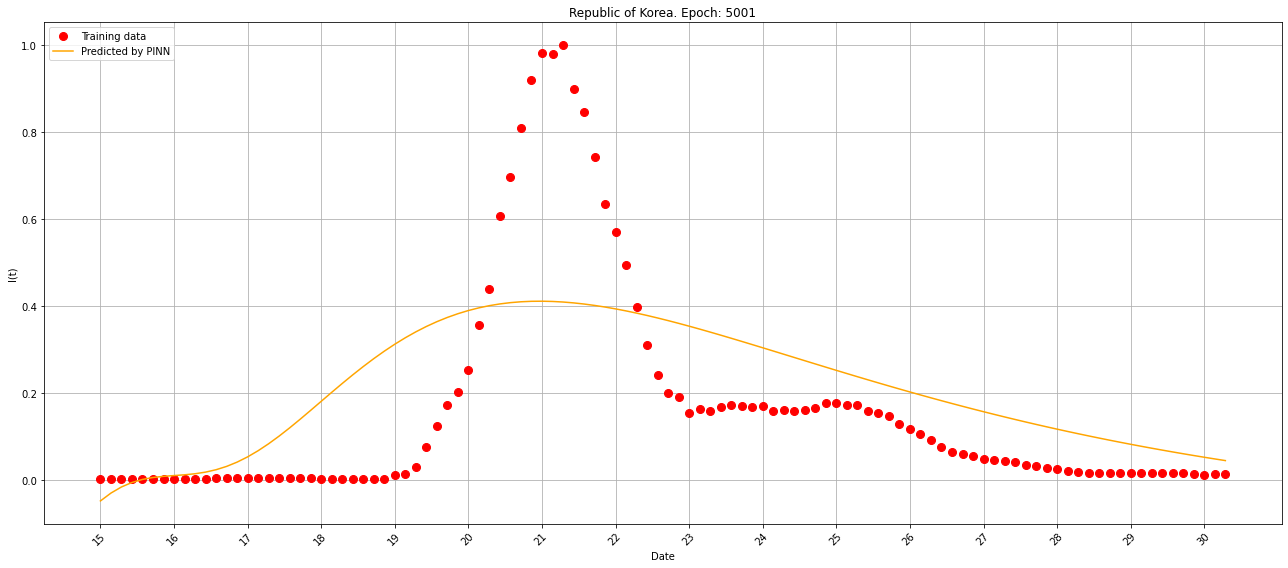

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 5101, MSE Loss = 0.028976934030652046, SIR Loss = 0.00015089326188899577, Total Loss = 0.029127826914191246
Epoch 5201, MSE Loss = 0.028061144053936005, SIR Loss = 0.00016375555424019694, Total Loss = 0.028224900364875793
Epoch 5301, MSE Loss = 0.02730669267475605, SIR Loss = 0.000182675474206917, Total Loss = 0.027489367872476578
Epoch 5401, MSE Loss = 0.031164368614554405, SIR Loss = 0.00020873187168035656, Total Loss = 0.031373102217912674
Epoch 5501, MSE Loss = 0.028659217059612274, SIR Loss = 0.0001611703628441319, Total Loss = 0.02882038801908493
Epoch 5601, MSE Loss = 0.02732265740633011, SIR Loss = 0.00016537679766770452, Total Loss = 0.02748803421854973
Epoch 5701, MSE Loss = 0.025497732684016228, SIR Loss = 0.00019096255709882826, Total Loss = 0.025688694790005684
Epoch 5801, MSE Loss = 0.01822696067392826, SIR Loss = 0.00027531516388989985, Total Loss = 0.01850227639079094
Epoch 5901, MSE Loss = 0.0050181979313492775, SIR Loss = 0.0007269713096320629, Total Loss = 0.00

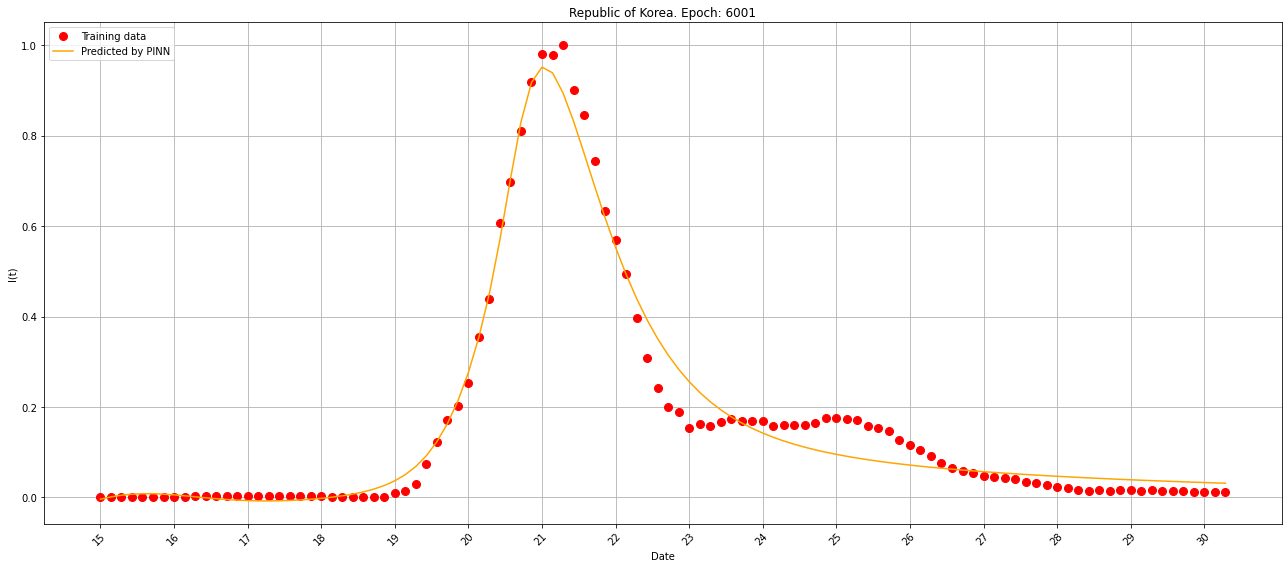

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 6101, MSE Loss = 0.0012003121664747596, SIR Loss = 0.0011982544092461467, Total Loss = 0.0023985665757209063
Epoch 6201, MSE Loss = 0.0009858605917543173, SIR Loss = 0.001214491785503924, Total Loss = 0.002200352493673563
Epoch 6301, MSE Loss = 0.0008121230639517307, SIR Loss = 0.0012229217682033777, Total Loss = 0.0020350448321551085
Epoch 6401, MSE Loss = 0.0006474210531450808, SIR Loss = 0.001227895962074399, Total Loss = 0.0018753169570118189
Epoch 6501, MSE Loss = 0.0005089292535558343, SIR Loss = 0.0012294505722820759, Total Loss = 0.0017383798258379102
Epoch 6601, MSE Loss = 0.0005323741934262216, SIR Loss = 0.0012281686067581177, Total Loss = 0.0017605428583920002
Epoch 6701, MSE Loss = 0.00038158049574121833, SIR Loss = 0.0012326664291322231, Total Loss = 0.0016142469830811024
Epoch 6801, MSE Loss = 0.00036911736242473125, SIR Loss = 0.0012331039179116488, Total Loss = 0.00160222128033638
Epoch 6901, MSE Loss = 0.00034720991970971227, SIR Loss = 0.0012337861116975546, To

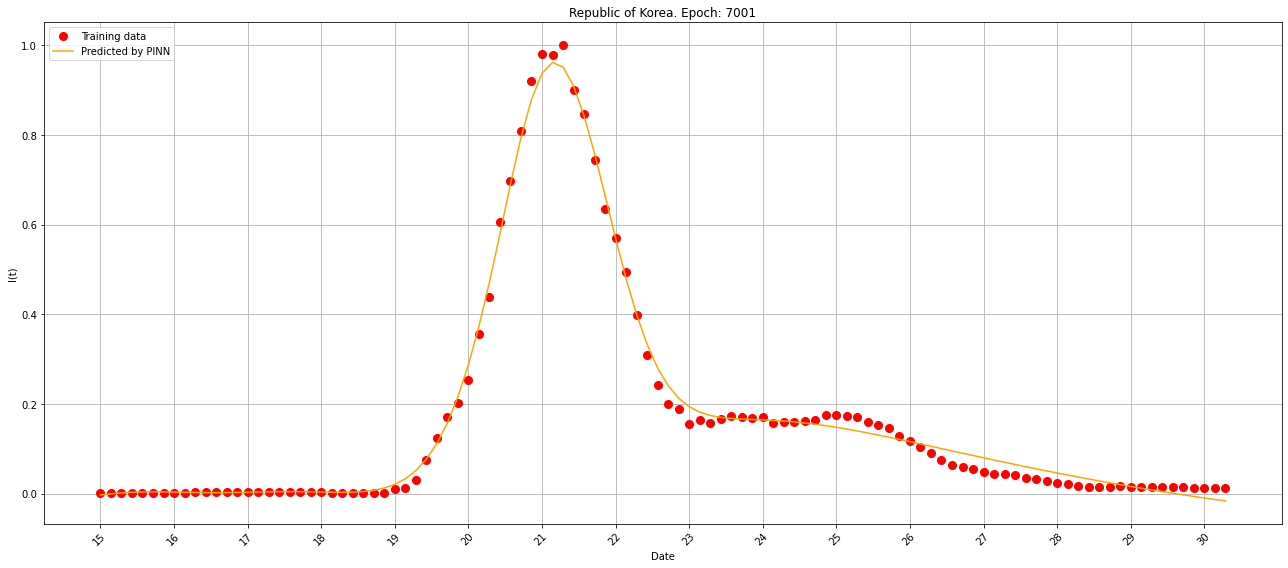

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 7101, MSE Loss = 0.0003235873009543866, SIR Loss = 0.0012345471186563373, Total Loss = 0.0015581344487145543
Epoch 7201, MSE Loss = 0.0003403839364182204, SIR Loss = 0.0012288725702092052, Total Loss = 0.001569256535731256
Epoch 7301, MSE Loss = 0.0003041558666154742, SIR Loss = 0.0012354934588074684, Total Loss = 0.0015396493254229426
Epoch 7401, MSE Loss = 0.0002955879317596555, SIR Loss = 0.0012362529523670673, Total Loss = 0.0015318408841267228
Epoch 7501, MSE Loss = 0.0002912088530138135, SIR Loss = 0.0012360007967799902, Total Loss = 0.0015272096497938037
Epoch 7601, MSE Loss = 0.00028098037000745535, SIR Loss = 0.0012374334037303925, Total Loss = 0.0015184137737378478
Epoch 7701, MSE Loss = 0.0002749937993939966, SIR Loss = 0.001237996038980782, Total Loss = 0.001512989867478609
Epoch 7801, MSE Loss = 0.000269515672698617, SIR Loss = 0.0012381270062178373, Total Loss = 0.0015076426789164543
Epoch 7901, MSE Loss = 0.0002641843748278916, SIR Loss = 0.0012390820775181055, Tot

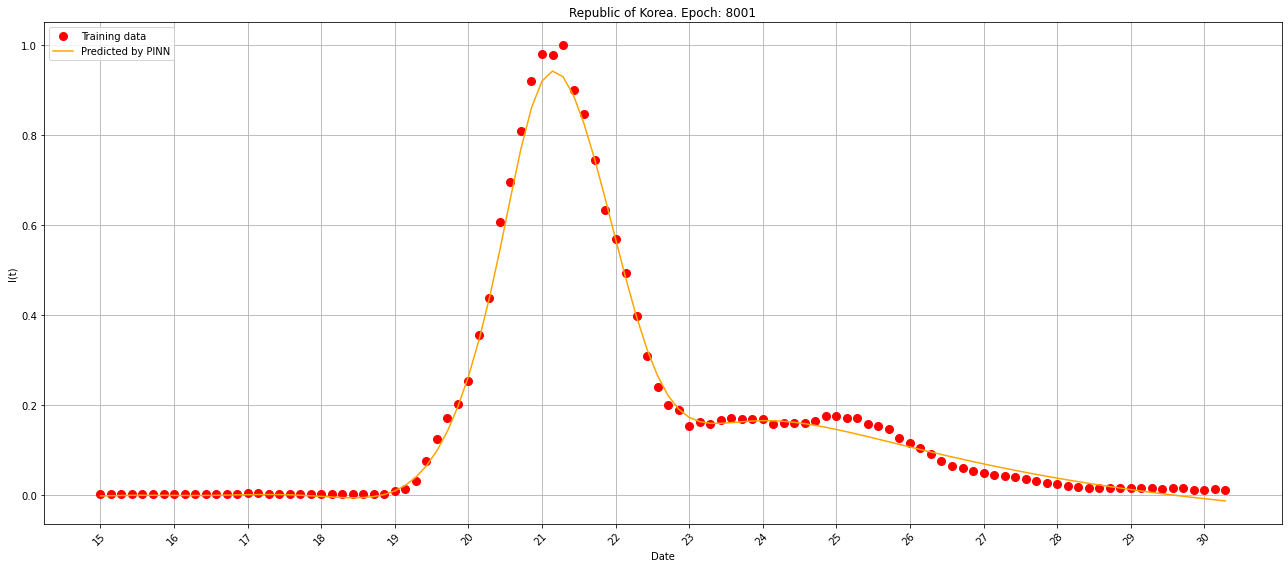

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 8101, MSE Loss = 0.00025616519269533455, SIR Loss = 0.0012397636892274022, Total Loss = 0.0014959288528189063
Epoch 8201, MSE Loss = 0.00025263818679377437, SIR Loss = 0.0012403992004692554, Total Loss = 0.0014930374454706907
Epoch 8301, MSE Loss = 0.0002496642409823835, SIR Loss = 0.0012405815068632364, Total Loss = 0.0014902458060532808
Epoch 8401, MSE Loss = 0.0002468376769684255, SIR Loss = 0.0012408406473696232, Total Loss = 0.0014876783825457096
Epoch 8501, MSE Loss = 0.0002571218356024474, SIR Loss = 0.0012341730762273073, Total Loss = 0.0014912949409335852
Epoch 8601, MSE Loss = 0.0002423313562758267, SIR Loss = 0.001241211430169642, Total Loss = 0.0014835428446531296
Epoch 8701, MSE Loss = 0.0002402366226306185, SIR Loss = 0.0012408008333295584, Total Loss = 0.0014810374705120921
Epoch 8801, MSE Loss = 0.0002500062109902501, SIR Loss = 0.0012363550486043096, Total Loss = 0.0014863612595945597
Epoch 8901, MSE Loss = 0.00023621863510925323, SIR Loss = 0.0012412779033184052

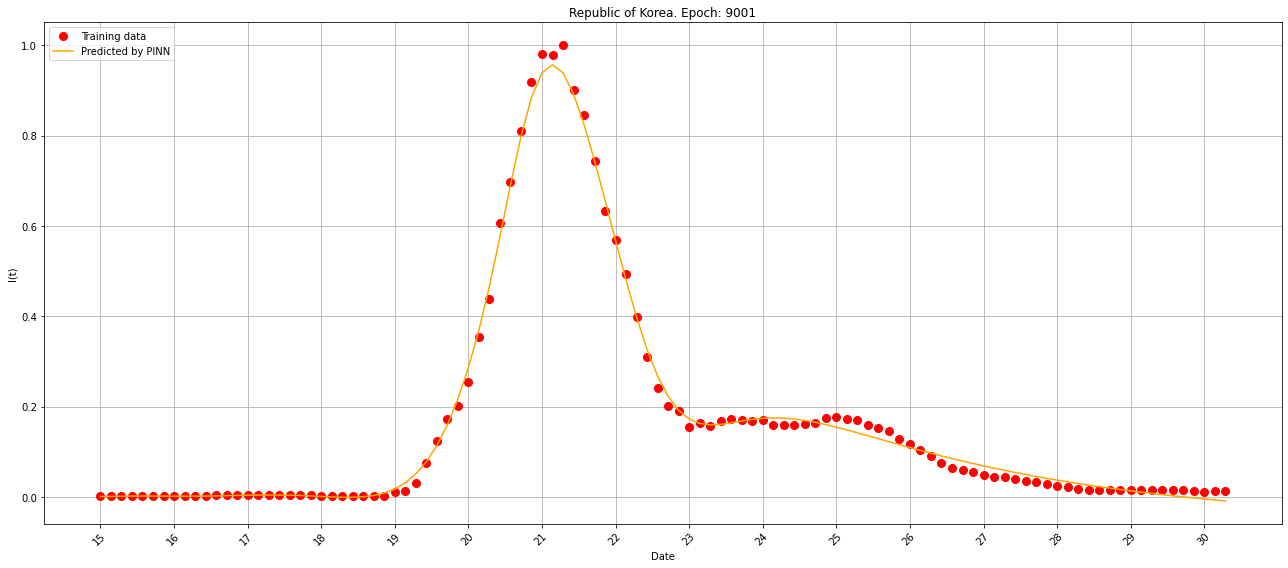

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 9101, MSE Loss = 0.00023557878739666194, SIR Loss = 0.0012391386553645134, Total Loss = 0.0014747173991054296
Epoch 9201, MSE Loss = 0.00023249418882187456, SIR Loss = 0.0012418486876413226, Total Loss = 0.0014743428910151124
Epoch 9301, MSE Loss = 0.0006420540739782155, SIR Loss = 0.0011931494809687138, Total Loss = 0.0018352034967392683
Epoch 9401, MSE Loss = 0.0002317803882760927, SIR Loss = 0.0012446840992197394, Total Loss = 0.0014764644438400865
Epoch 9501, MSE Loss = 0.00039764423854649067, SIR Loss = 0.0012538810260593891, Total Loss = 0.0016515252646058798
Epoch 9601, MSE Loss = 0.00024785485584288836, SIR Loss = 0.0012331961188465357, Total Loss = 0.001481050974689424
Epoch 9701, MSE Loss = 0.0004131625755690038, SIR Loss = 0.001253351685591042, Total Loss = 0.001666514202952385
Epoch 9801, MSE Loss = 0.0002235913707409054, SIR Loss = 0.0012404531007632613, Total Loss = 0.0014640444424003363
Epoch 9901, MSE Loss = 0.00024028729239944369, SIR Loss = 0.0012461168225854635

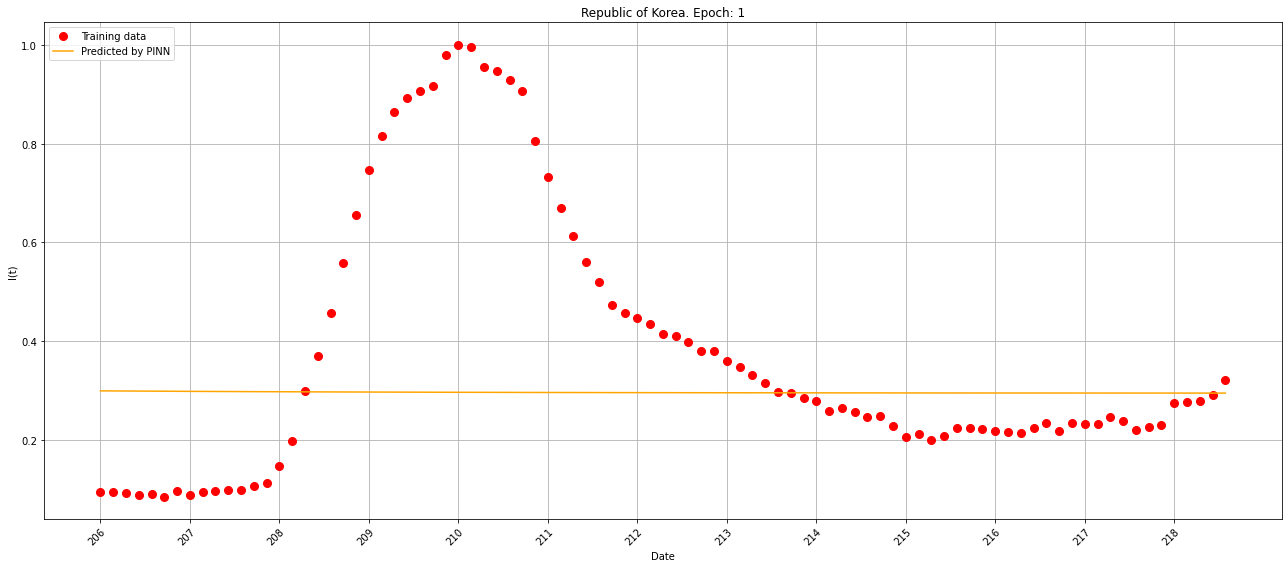

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.07092864066362381, SIR Loss = 4.431974343077627e-09, Total Loss = 0.0709286481142044
Epoch 201, MSE Loss = 0.0709175392985344, SIR Loss = 7.78212339014317e-09, Total Loss = 0.07091754674911499
Epoch 301, MSE Loss = 0.0709063783288002, SIR Loss = 1.2370139579331862e-08, Total Loss = 0.0709063932299614
Epoch 401, MSE Loss = 0.07089177519083023, SIR Loss = 1.9795916017528725e-08, Total Loss = 0.07089179754257202
Epoch 501, MSE Loss = 0.07087189704179764, SIR Loss = 3.222398348157185e-08, Total Loss = 0.07087192684412003
Epoch 601, MSE Loss = 0.07084418088197708, SIR Loss = 5.34873514368428e-08, Total Loss = 0.07084423303604126
Epoch 701, MSE Loss = 0.07080510258674622, SIR Loss = 9.03434198562536e-08, Total Loss = 0.07080519199371338
Epoch 801, MSE Loss = 0.07074993848800659, SIR Loss = 1.5442793710462865e-07, Total Loss = 0.07075009495019913
Epoch 901, MSE Loss = 0.0706731304526329, SIR Loss = 2.6633068728187936e-07, Total Loss = 0.0706733986735344
Epoch 1001, MSE

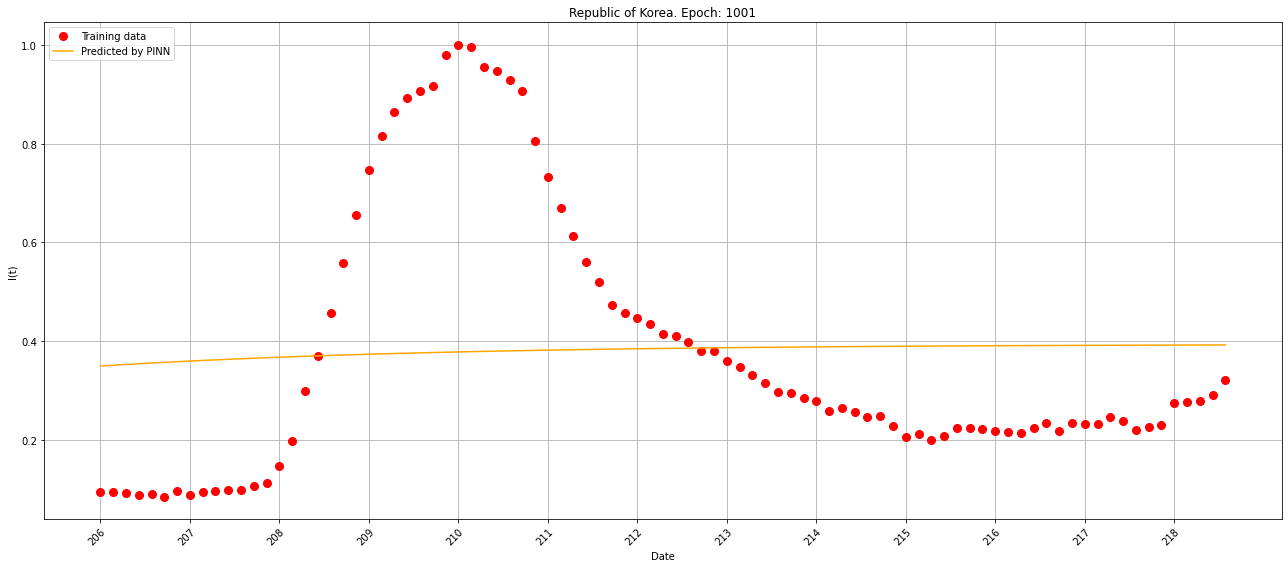

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.07046475261449814, SIR Loss = 5.81836502533406e-07, Total Loss = 0.0704653337597847
Epoch 1201, MSE Loss = 0.07027266174554825, SIR Loss = 1.1795123100455385e-06, Total Loss = 0.07027383893728256
Epoch 1301, MSE Loss = 0.0702793225646019, SIR Loss = 1.6735720009819488e-06, Total Loss = 0.0702809989452362
Epoch 1401, MSE Loss = 0.07032853364944458, SIR Loss = 2.086778749799123e-06, Total Loss = 0.07033061981201172
Epoch 1501, MSE Loss = 0.06986935436725616, SIR Loss = 2.7388987291487865e-06, Total Loss = 0.06987209618091583
Epoch 1601, MSE Loss = 0.06980279088020325, SIR Loss = 4.500312115851557e-06, Total Loss = 0.06980729103088379
Epoch 1701, MSE Loss = 0.07094954699277878, SIR Loss = 4.677409154441037e-11, Total Loss = 0.07094954699277878
Epoch 1801, MSE Loss = 0.07177643477916718, SIR Loss = 5.604994801622354e-10, Total Loss = 0.07177643477916718
Epoch 1901, MSE Loss = 0.07095994055271149, SIR Loss = 2.2687428324896786e-11, Total Loss = 0.07095994055271149
E

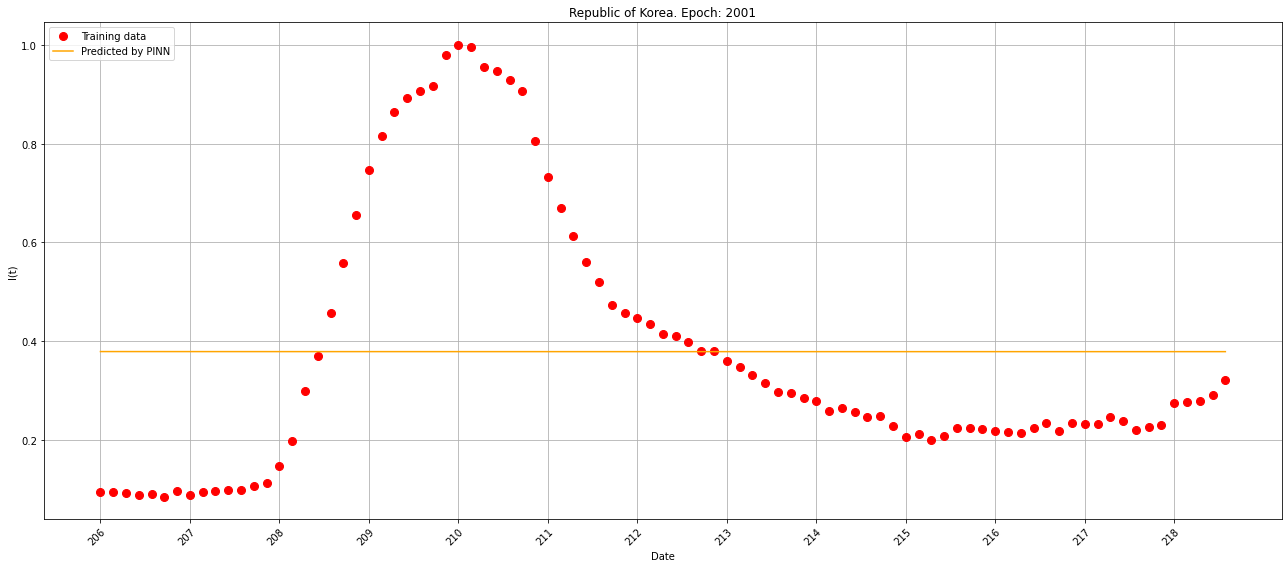

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 2101, MSE Loss = 0.0709562823176384, SIR Loss = 4.6277066380329135e-12, Total Loss = 0.0709562823176384
Epoch 2201, MSE Loss = 0.07095556706190109, SIR Loss = 2.7923531542572988e-12, Total Loss = 0.07095556706190109
Epoch 2301, MSE Loss = 0.07095511257648468, SIR Loss = 1.8400461276185665e-12, Total Loss = 0.07095511257648468
Epoch 2401, MSE Loss = 0.07095476984977722, SIR Loss = 1.287524340615187e-12, Total Loss = 0.07095476984977722
Epoch 2501, MSE Loss = 0.07095452398061752, SIR Loss = 9.433028360164575e-13, Total Loss = 0.07095452398061752
Epoch 2601, MSE Loss = 0.0709543451666832, SIR Loss = 7.131199385342069e-13, Total Loss = 0.0709543451666832
Epoch 2701, MSE Loss = 0.07095417380332947, SIR Loss = 5.543655270077996e-13, Total Loss = 0.07095417380332947
Early stopping at epoch 2782.
Epoch 1, MSE Loss = 0.06450864672660828, SIR Loss = 9.063044913287263e-18, Total Loss = 0.06450864672660828


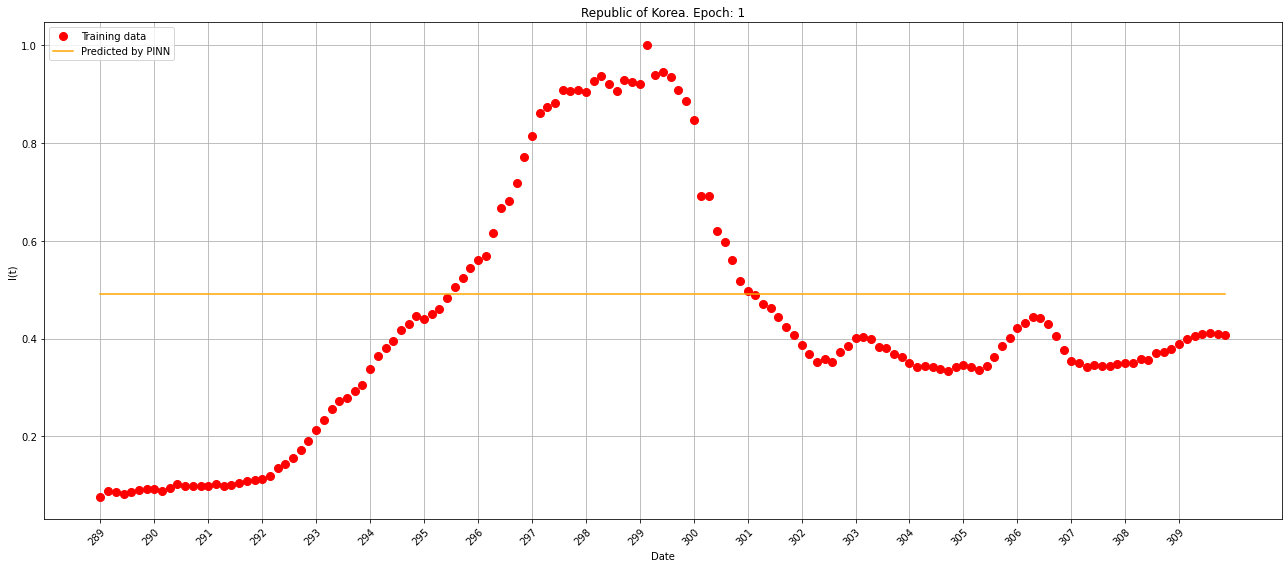

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.06027010828256607, SIR Loss = 7.228903342593185e-08, Total Loss = 0.06027017906308174
Epoch 201, MSE Loss = 0.05646902695298195, SIR Loss = 1.9518847693689167e-06, Total Loss = 0.05647097900509834
Epoch 301, MSE Loss = 0.05390205979347229, SIR Loss = 3.752861402972485e-06, Total Loss = 0.05390581116080284
Epoch 401, MSE Loss = 0.04913220927119255, SIR Loss = 4.613112650986295e-06, Total Loss = 0.049136821180582047
Epoch 501, MSE Loss = 0.06174353510141373, SIR Loss = 1.3549252314936483e-15, Total Loss = 0.06174353510141373
Epoch 601, MSE Loss = 0.06174322962760925, SIR Loss = 1.3549252314936483e-15, Total Loss = 0.06174322962760925
Epoch 701, MSE Loss = 0.061743222177028656, SIR Loss = 1.3549252314936483e-15, Total Loss = 0.061743222177028656
Epoch 801, MSE Loss = 0.061743222177028656, SIR Loss = 1.3549252314936483e-15, Total Loss = 0.061743222177028656
Epoch 901, MSE Loss = 0.061743222177028656, SIR Loss = 1.3247150602759949e-15, Total Loss = 0.0617432221770286

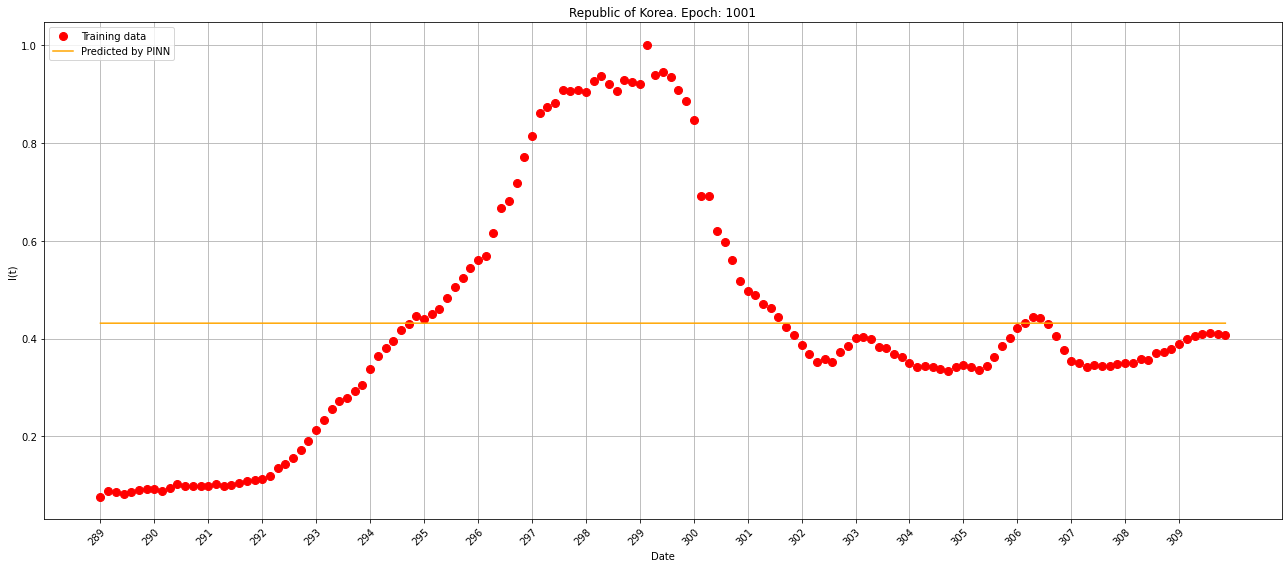

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.06174322962760925, SIR Loss = 1.288462897166458e-15, Total Loss = 0.06174322962760925
Epoch 1201, MSE Loss = 0.06174324452877045, SIR Loss = 1.276378807503573e-15, Total Loss = 0.06174324452877045
Epoch 1301, MSE Loss = 0.061743222177028656, SIR Loss = 1.276378807503573e-15, Total Loss = 0.061743222177028656
Epoch 1401, MSE Loss = 0.06174323707818985, SIR Loss = 1.276378807503573e-15, Total Loss = 0.06174323707818985
Early stopping at epoch 1406.
Epoch 1, MSE Loss = 0.05917935445904732, SIR Loss = 0.0, Total Loss = 0.05917935445904732


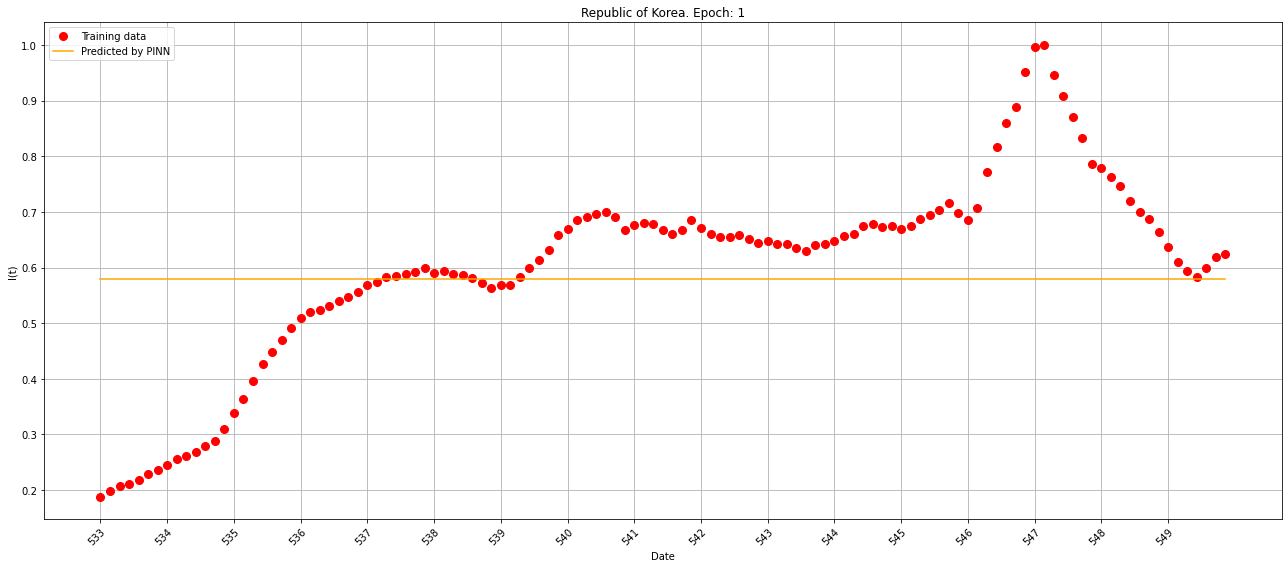

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.029361717402935028, SIR Loss = 0.0, Total Loss = 0.029361717402935028
Epoch 201, MSE Loss = 0.029361523687839508, SIR Loss = 0.0, Total Loss = 0.029361523687839508
Epoch 301, MSE Loss = 0.02936152182519436, SIR Loss = 0.0, Total Loss = 0.02936152182519436
Epoch 401, MSE Loss = 0.02936152182519436, SIR Loss = 0.0, Total Loss = 0.02936152182519436
Epoch 501, MSE Loss = 0.02936152182519436, SIR Loss = 0.0, Total Loss = 0.02936152182519436
Epoch 601, MSE Loss = 0.029361523687839508, SIR Loss = 0.0, Total Loss = 0.029361523687839508
Epoch 701, MSE Loss = 0.02936152182519436, SIR Loss = 0.0, Total Loss = 0.02936152182519436
Epoch 801, MSE Loss = 0.02936152182519436, SIR Loss = 0.0, Total Loss = 0.02936152182519436
Epoch 901, MSE Loss = 0.02936152182519436, SIR Loss = 0.0, Total Loss = 0.02936152182519436
Epoch 1001, MSE Loss = 0.02936152182519436, SIR Loss = 0.0, Total Loss = 0.02936152182519436


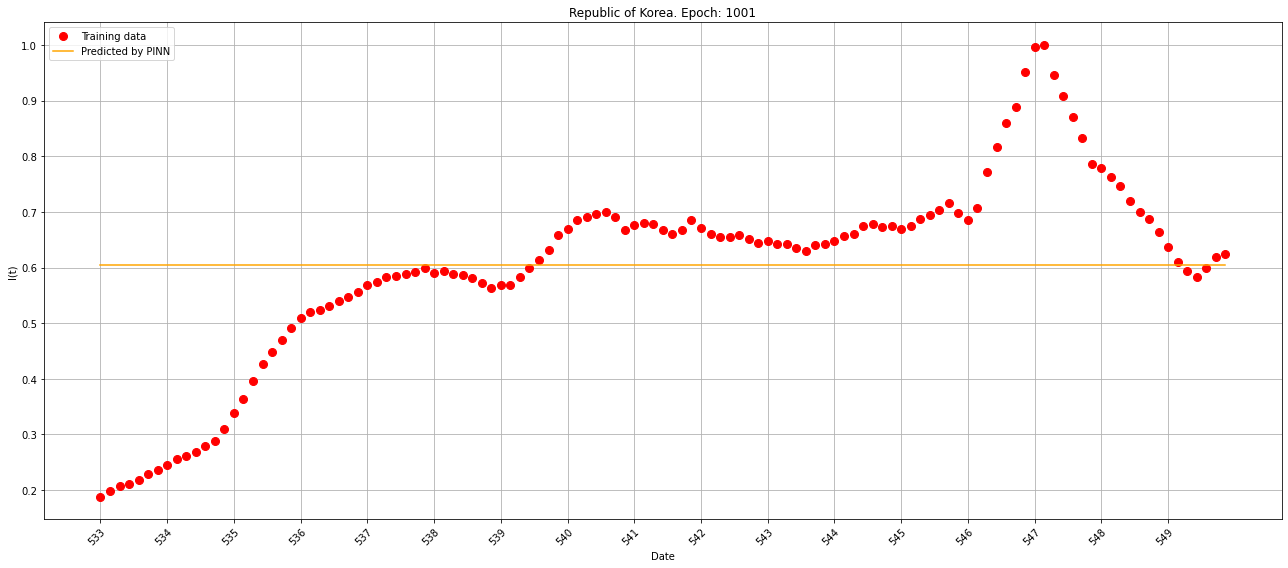

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.029361523687839508, SIR Loss = 0.0, Total Loss = 0.029361523687839508
Early stopping at epoch 1132.
Epoch 1, MSE Loss = 0.20133043825626373, SIR Loss = 0.0, Total Loss = 0.20133043825626373


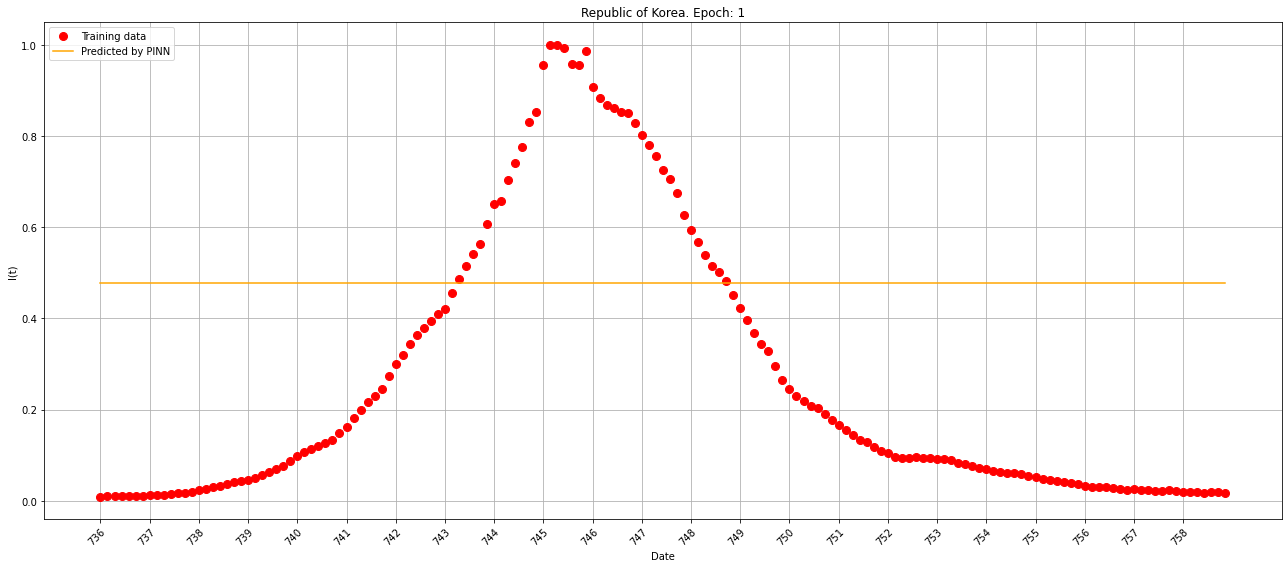

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.08977454155683517, SIR Loss = 0.0, Total Loss = 0.08977454155683517
Epoch 201, MSE Loss = 0.08977305144071579, SIR Loss = 0.0, Total Loss = 0.08977305144071579
Epoch 301, MSE Loss = 0.08977305144071579, SIR Loss = 0.0, Total Loss = 0.08977305144071579
Epoch 401, MSE Loss = 0.08977305144071579, SIR Loss = 0.0, Total Loss = 0.08977305144071579
Epoch 501, MSE Loss = 0.08977305144071579, SIR Loss = 0.0, Total Loss = 0.08977305144071579
Epoch 601, MSE Loss = 0.08977305144071579, SIR Loss = 0.0, Total Loss = 0.08977305144071579
Epoch 701, MSE Loss = 0.08977305144071579, SIR Loss = 0.0, Total Loss = 0.08977305144071579
Epoch 801, MSE Loss = 0.08977305144071579, SIR Loss = 0.0, Total Loss = 0.08977305144071579
Epoch 901, MSE Loss = 0.08977305144071579, SIR Loss = 0.0, Total Loss = 0.08977305144071579
Epoch 1001, MSE Loss = 0.08977305144071579, SIR Loss = 0.0, Total Loss = 0.08977305144071579


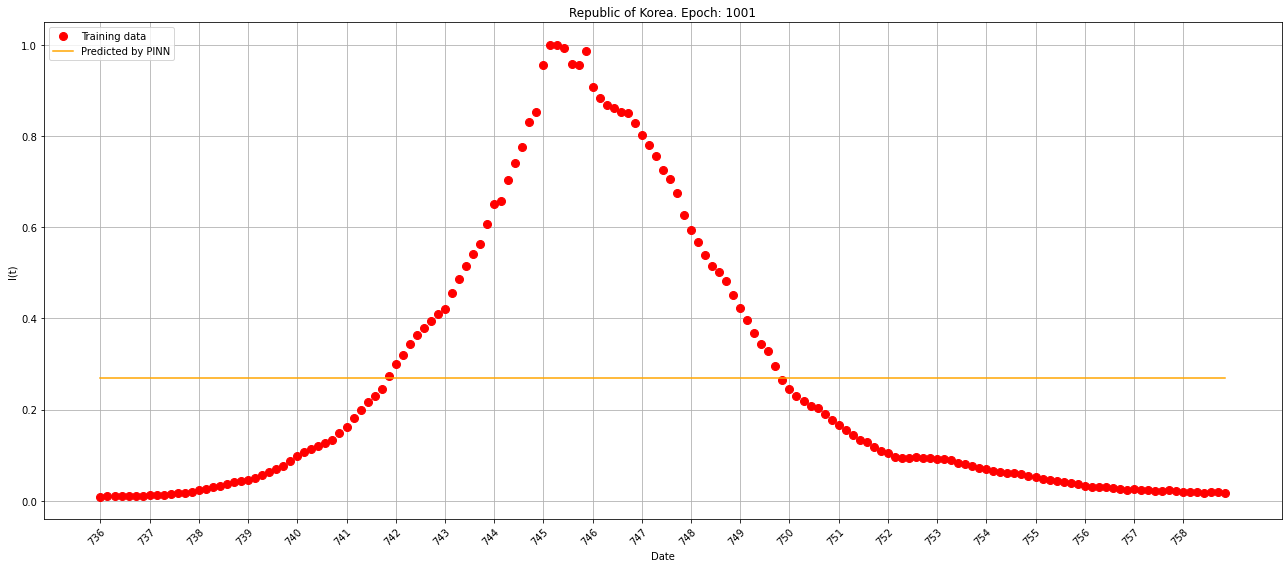

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.08977305144071579, SIR Loss = 0.0, Total Loss = 0.08977305144071579
Early stopping at epoch 1170.
Epoch 1, MSE Loss = 0.11253215372562408, SIR Loss = 0.0, Total Loss = 0.11253215372562408


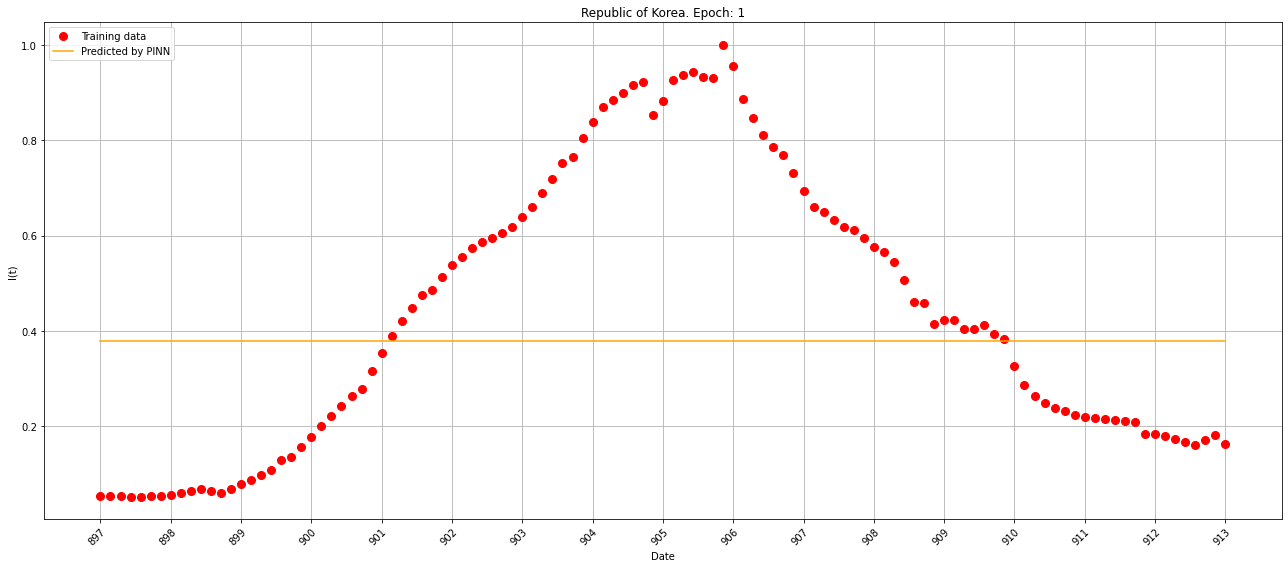

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.0843355804681778, SIR Loss = 0.0, Total Loss = 0.0843355804681778
Epoch 201, MSE Loss = 0.08433536440134048, SIR Loss = 0.0, Total Loss = 0.08433536440134048
Epoch 301, MSE Loss = 0.08433536440134048, SIR Loss = 0.0, Total Loss = 0.08433536440134048
Epoch 401, MSE Loss = 0.08433536440134048, SIR Loss = 0.0, Total Loss = 0.08433536440134048
Epoch 501, MSE Loss = 0.08433536440134048, SIR Loss = 0.0, Total Loss = 0.08433536440134048
Epoch 601, MSE Loss = 0.08433536440134048, SIR Loss = 0.0, Total Loss = 0.08433536440134048
Epoch 701, MSE Loss = 0.08433536440134048, SIR Loss = 0.0, Total Loss = 0.08433536440134048
Epoch 801, MSE Loss = 0.08433536440134048, SIR Loss = 0.0, Total Loss = 0.08433536440134048
Epoch 901, MSE Loss = 0.08433536440134048, SIR Loss = 0.0, Total Loss = 0.08433536440134048
Epoch 1001, MSE Loss = 0.08433536440134048, SIR Loss = 0.0, Total Loss = 0.08433536440134048


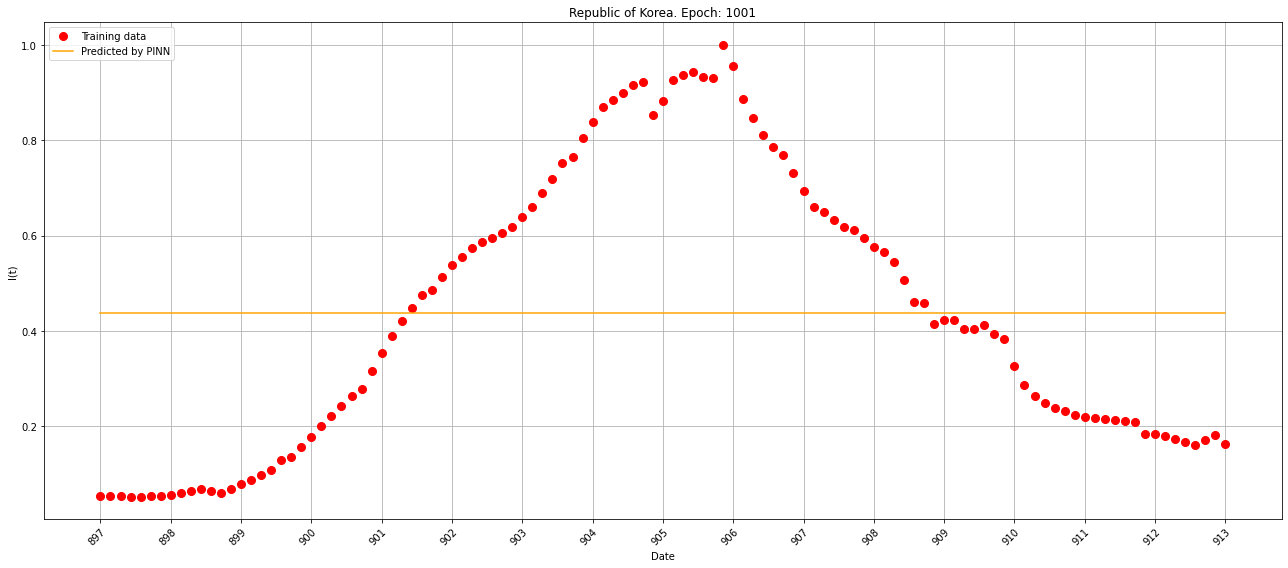

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.08433536440134048, SIR Loss = 0.0, Total Loss = 0.08433536440134048
Early stopping at epoch 1165.
Epoch 1, MSE Loss = 0.10242060571908951, SIR Loss = 0.0, Total Loss = 0.10242060571908951


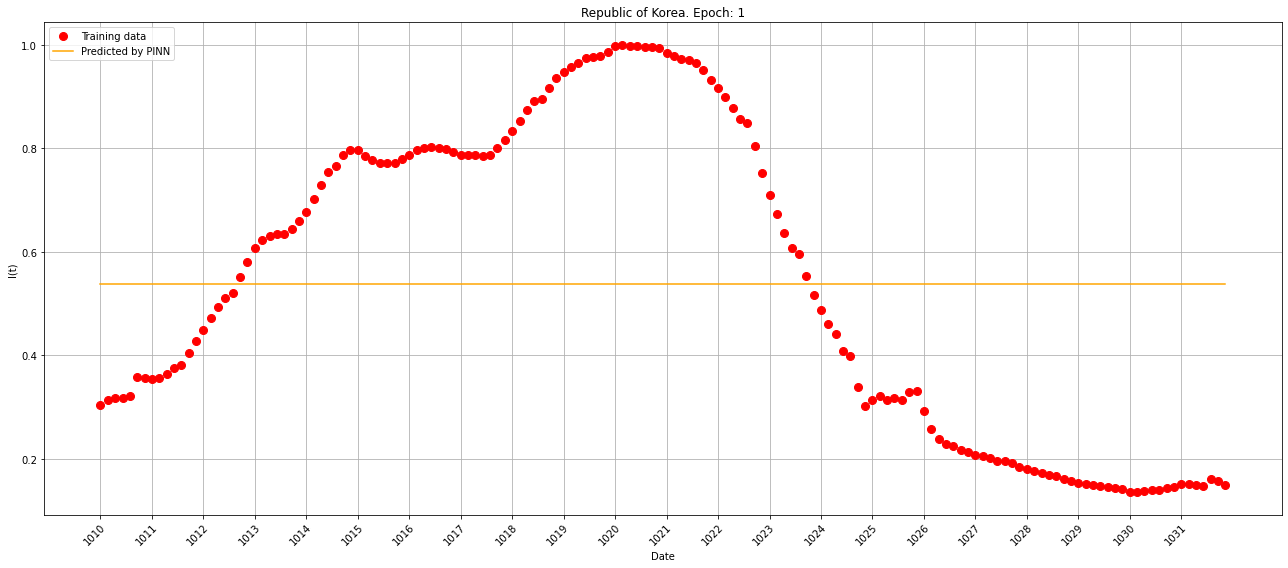

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.09073226153850555, SIR Loss = 0.0, Total Loss = 0.09073226153850555
Epoch 201, MSE Loss = 0.09073223918676376, SIR Loss = 0.0, Total Loss = 0.09073223918676376
Epoch 301, MSE Loss = 0.09073224663734436, SIR Loss = 0.0, Total Loss = 0.09073224663734436
Epoch 401, MSE Loss = 0.09073224663734436, SIR Loss = 0.0, Total Loss = 0.09073224663734436
Epoch 501, MSE Loss = 0.09073224663734436, SIR Loss = 0.0, Total Loss = 0.09073224663734436
Epoch 601, MSE Loss = 0.09073224663734436, SIR Loss = 0.0, Total Loss = 0.09073224663734436
Epoch 701, MSE Loss = 0.09073224663734436, SIR Loss = 0.0, Total Loss = 0.09073224663734436
Epoch 801, MSE Loss = 0.09073224663734436, SIR Loss = 0.0, Total Loss = 0.09073224663734436
Epoch 901, MSE Loss = 0.09073224663734436, SIR Loss = 0.0, Total Loss = 0.09073224663734436
Epoch 1001, MSE Loss = 0.09073224663734436, SIR Loss = 0.0, Total Loss = 0.09073224663734436


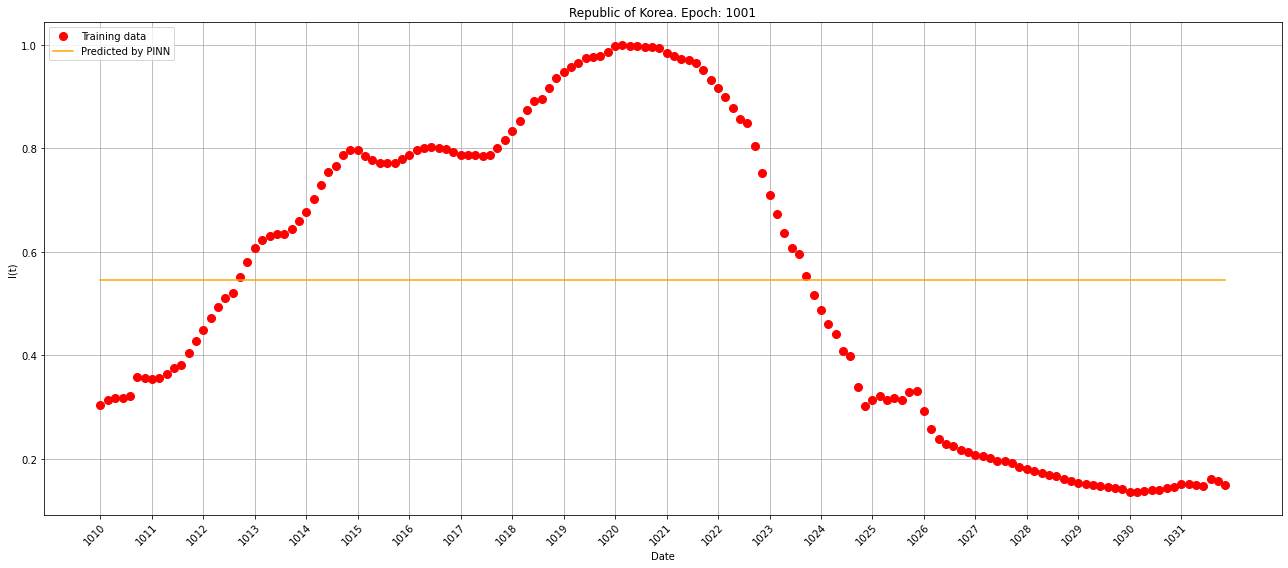

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.09073224663734436, SIR Loss = 0.0, Total Loss = 0.09073224663734436
Early stopping at epoch 1135.
Epoch 1, MSE Loss = 0.27730950713157654, SIR Loss = 0.12570452690124512, Total Loss = 0.40301403403282166


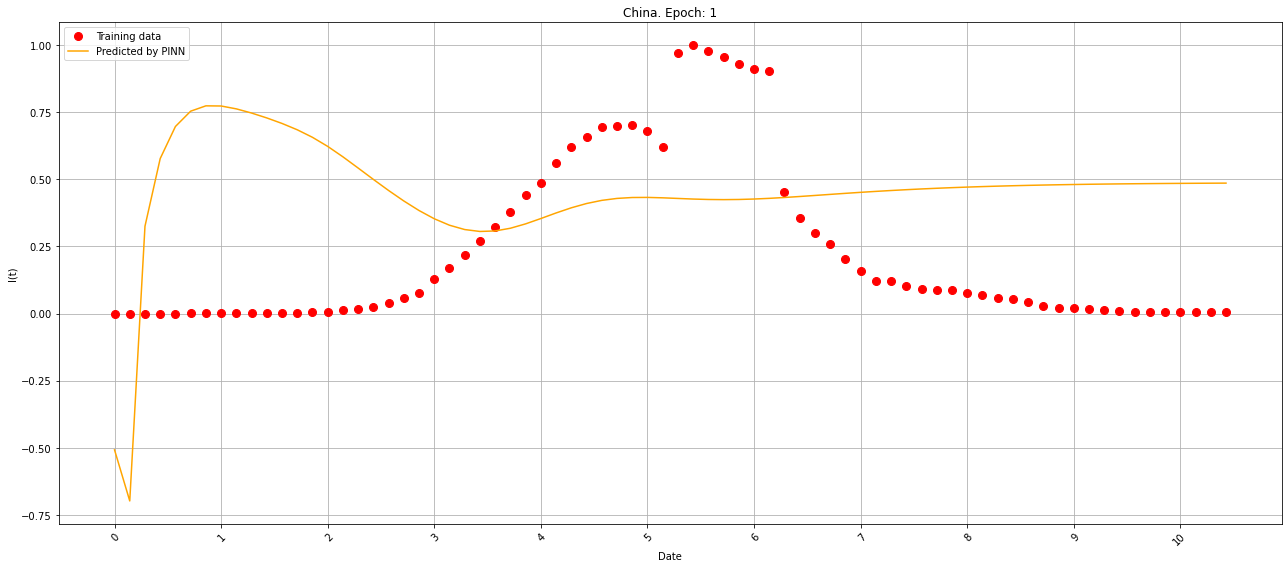

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.002823777496814728, SIR Loss = 0.0015741263050585985, Total Loss = 0.004397903569042683
Epoch 201, MSE Loss = 0.0019608279690146446, SIR Loss = 0.001729533658362925, Total Loss = 0.003690361510962248
Epoch 301, MSE Loss = 0.001891933148726821, SIR Loss = 0.001742583466693759, Total Loss = 0.00363451661542058
Epoch 401, MSE Loss = 0.0018439262639731169, SIR Loss = 0.001746370573528111, Total Loss = 0.0035902969539165497
Epoch 501, MSE Loss = 0.0017868991708382964, SIR Loss = 0.001746930181980133, Total Loss = 0.0035338294692337513
Epoch 601, MSE Loss = 0.0017049621092155576, SIR Loss = 0.0017581457505002618, Total Loss = 0.0034631078597158194
Epoch 701, MSE Loss = 0.0016055515734478831, SIR Loss = 0.001779974321834743, Total Loss = 0.003385525895282626
Epoch 801, MSE Loss = 0.0014976206002756953, SIR Loss = 0.001804796396754682, Total Loss = 0.0033024169970303774
Epoch 901, MSE Loss = 0.001377398963086307, SIR Loss = 0.0018427778268232942, Total Loss = 0.00322017

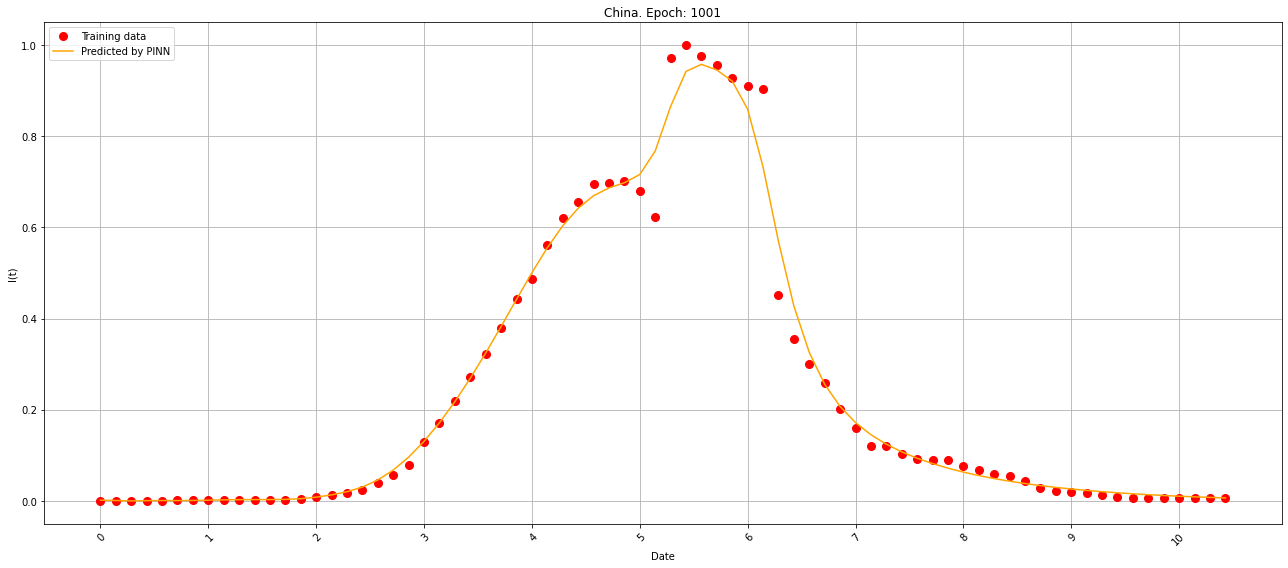

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.0011756767053157091, SIR Loss = 0.0019387666834518313, Total Loss = 0.0031144432723522186
Epoch 1201, MSE Loss = 0.0011811478761956096, SIR Loss = 0.001986463787034154, Total Loss = 0.0031676115468144417
Epoch 1301, MSE Loss = 0.0010592613834887743, SIR Loss = 0.002015557372942567, Total Loss = 0.003074818756431341
Epoch 1401, MSE Loss = 0.0010230649495497346, SIR Loss = 0.0020411203149706125, Total Loss = 0.003064185380935669
Epoch 1501, MSE Loss = 0.0009973172564059496, SIR Loss = 0.0020585947204381227, Total Loss = 0.0030559119768440723
Epoch 1601, MSE Loss = 0.0009747631847858429, SIR Loss = 0.0020721263717859983, Total Loss = 0.0030468895565718412
Epoch 1701, MSE Loss = 0.0009568873210810125, SIR Loss = 0.002080487785860896, Total Loss = 0.0030373751651495695
Epoch 1801, MSE Loss = 0.0009409124031662941, SIR Loss = 0.0020884715486317873, Total Loss = 0.0030293839517980814
Epoch 1901, MSE Loss = 0.0009201053180731833, SIR Loss = 0.0020882301032543182, Total

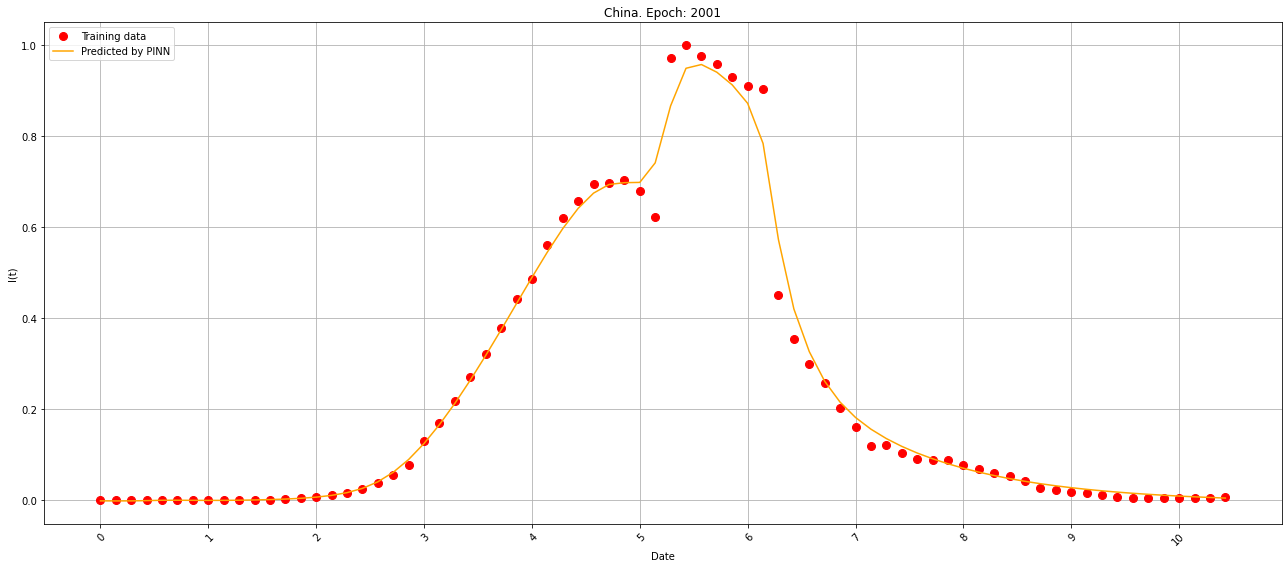

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 2101, MSE Loss = 0.0009835114469751716, SIR Loss = 0.0021143376361578703, Total Loss = 0.00309784896671772
Epoch 2201, MSE Loss = 0.0009816980455070734, SIR Loss = 0.002219723304733634, Total Loss = 0.0032014213502407074
Epoch 2301, MSE Loss = 0.0025869724340736866, SIR Loss = 0.0018439935520291328, Total Loss = 0.0044309659861028194
Epoch 2401, MSE Loss = 0.0011082906275987625, SIR Loss = 0.001734476420097053, Total Loss = 0.0028427671641111374
Epoch 2501, MSE Loss = 0.0010351665550842881, SIR Loss = 0.0017350551206618547, Total Loss = 0.0027702217921614647
Epoch 2601, MSE Loss = 0.0009864498861134052, SIR Loss = 0.0017241070745512843, Total Loss = 0.0027105570770800114
Epoch 2701, MSE Loss = 0.0009322208934463561, SIR Loss = 0.0017145028105005622, Total Loss = 0.002646723762154579
Epoch 2801, MSE Loss = 0.0008600425790064037, SIR Loss = 0.0017053018091246486, Total Loss = 0.0025653443299233913
Epoch 2901, MSE Loss = 0.0008696233853697777, SIR Loss = 0.0018442055443301797, Total

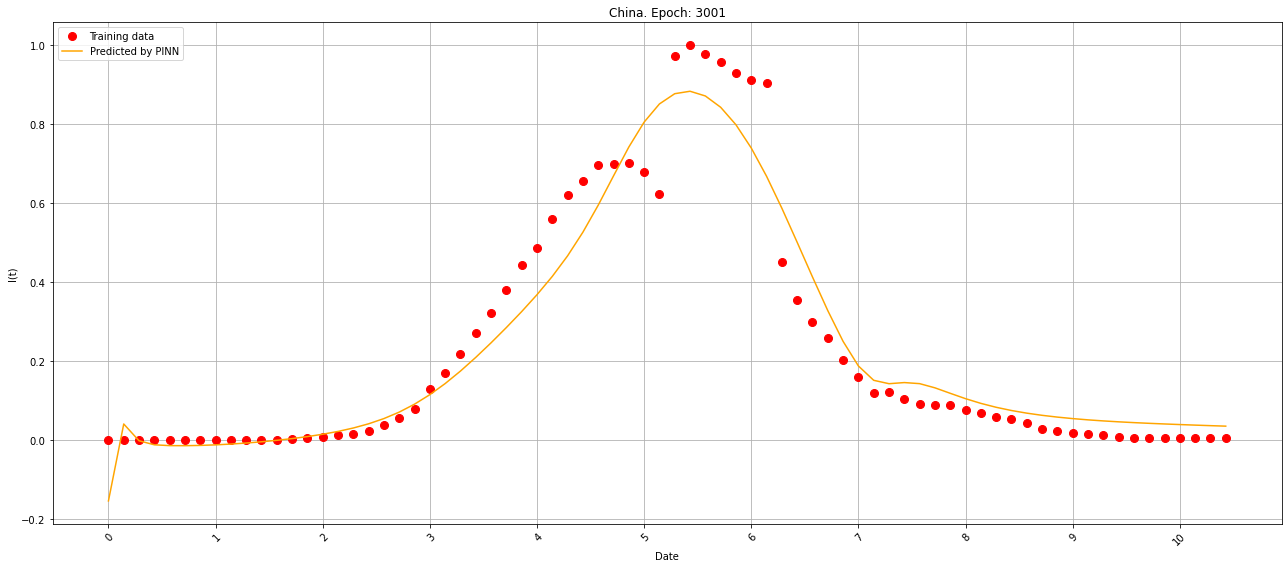

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 3101, MSE Loss = 0.0015763111878186464, SIR Loss = 0.0018375683575868607, Total Loss = 0.003413879545405507
Epoch 3201, MSE Loss = 0.001454205485060811, SIR Loss = 0.0018562217010185122, Total Loss = 0.0033104270696640015
Epoch 3301, MSE Loss = 0.0013034718576818705, SIR Loss = 0.001892478670924902, Total Loss = 0.0031959505286067724
Epoch 3401, MSE Loss = 0.0011445613345131278, SIR Loss = 0.001956397434696555, Total Loss = 0.003100958652794361
Epoch 3501, MSE Loss = 0.0010378379374742508, SIR Loss = 0.0020158158149570227, Total Loss = 0.0030536537524312735
Epoch 3601, MSE Loss = 0.0009840012062340975, SIR Loss = 0.002055952325463295, Total Loss = 0.0030399535316973925
Epoch 3701, MSE Loss = 0.0009448294877074659, SIR Loss = 0.0020826535765081644, Total Loss = 0.003027483122423291
Epoch 3801, MSE Loss = 0.0009322233963757753, SIR Loss = 0.002095793141052127, Total Loss = 0.0030280165374279022
Epoch 3901, MSE Loss = 0.0009096684516407549, SIR Loss = 0.0021091208327561617, Total Lo

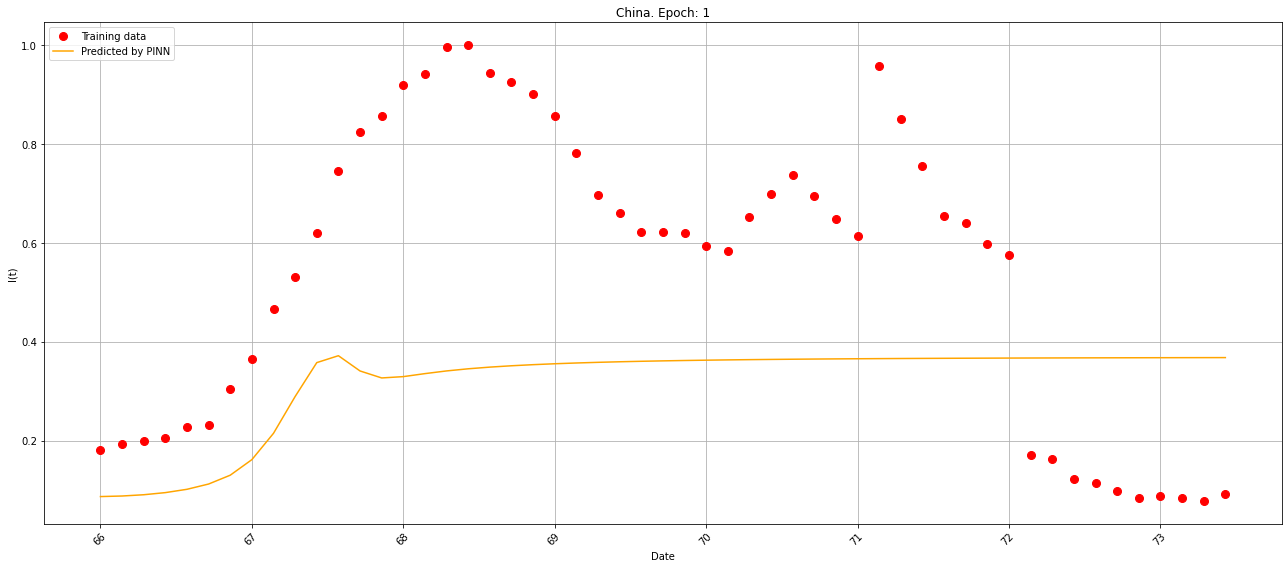

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.013538964092731476, SIR Loss = 0.0013686302118003368, Total Loss = 0.0149075947701931
Epoch 201, MSE Loss = 0.007934767752885818, SIR Loss = 0.001528032124042511, Total Loss = 0.00946279987692833
Epoch 301, MSE Loss = 0.002868402749300003, SIR Loss = 0.0023567487951368093, Total Loss = 0.005225151777267456
Epoch 401, MSE Loss = 0.002693982794880867, SIR Loss = 0.0024162898771464825, Total Loss = 0.0051102726720273495
Epoch 501, MSE Loss = 0.0026303462218493223, SIR Loss = 0.002439272589981556, Total Loss = 0.005069619044661522
Epoch 601, MSE Loss = 0.0025938095059245825, SIR Loss = 0.002451421460136771, Total Loss = 0.005045230966061354
Epoch 701, MSE Loss = 0.002662135288119316, SIR Loss = 0.0024479124695062637, Total Loss = 0.00511004775762558
Epoch 801, MSE Loss = 0.0030975874979048967, SIR Loss = 0.0024116875138133764, Total Loss = 0.005509275011718273
Epoch 901, MSE Loss = 0.002604865236207843, SIR Loss = 0.0024531253147870302, Total Loss = 0.00505799055099

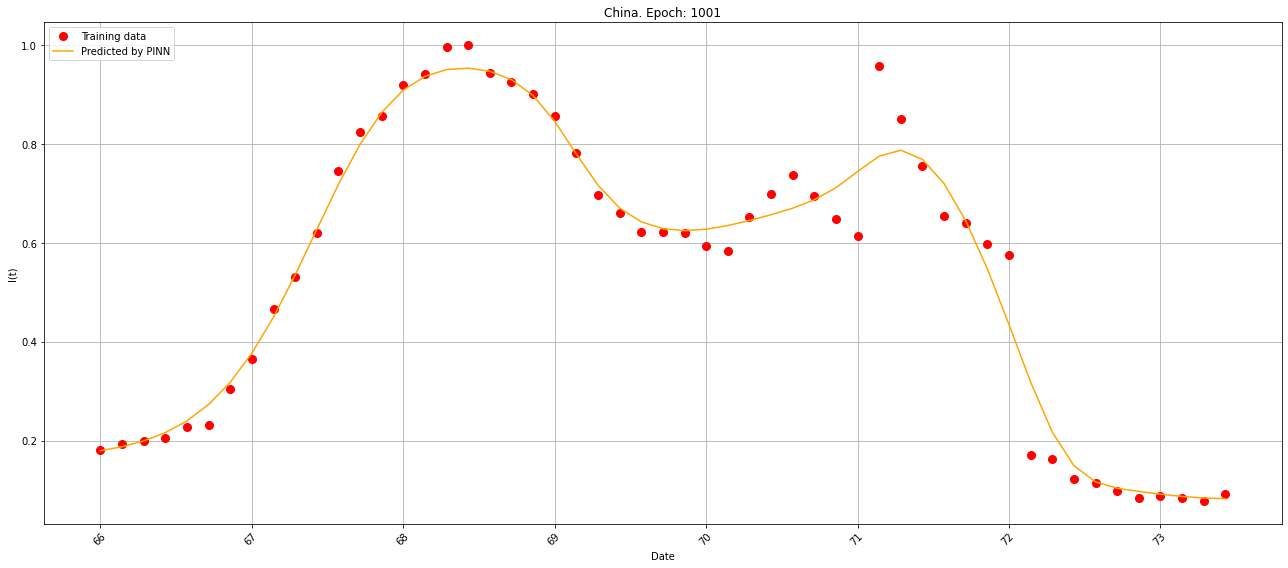

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.0024082728195935488, SIR Loss = 0.0024903584271669388, Total Loss = 0.004898631013929844
Epoch 1201, MSE Loss = 0.002336303237825632, SIR Loss = 0.0025112165603786707, Total Loss = 0.0048475200310349464
Epoch 1301, MSE Loss = 0.002338461810722947, SIR Loss = 0.002538104308769107, Total Loss = 0.004876566119492054
Epoch 1401, MSE Loss = 0.0020886810962110758, SIR Loss = 0.0025670204777270555, Total Loss = 0.004655701573938131
Epoch 1501, MSE Loss = 0.001982111483812332, SIR Loss = 0.0026003089733421803, Total Loss = 0.004582420457154512
Epoch 1601, MSE Loss = 0.0020893600303679705, SIR Loss = 0.002638939069584012, Total Loss = 0.0047282990999519825
Epoch 1701, MSE Loss = 0.0018241744255647063, SIR Loss = 0.002645215019583702, Total Loss = 0.00446938956156373
Epoch 1801, MSE Loss = 0.0017634517280384898, SIR Loss = 0.002667694352567196, Total Loss = 0.0044311461970210075
Epoch 1901, MSE Loss = 0.0018328691367059946, SIR Loss = 0.0027356725186109543, Total Loss = 

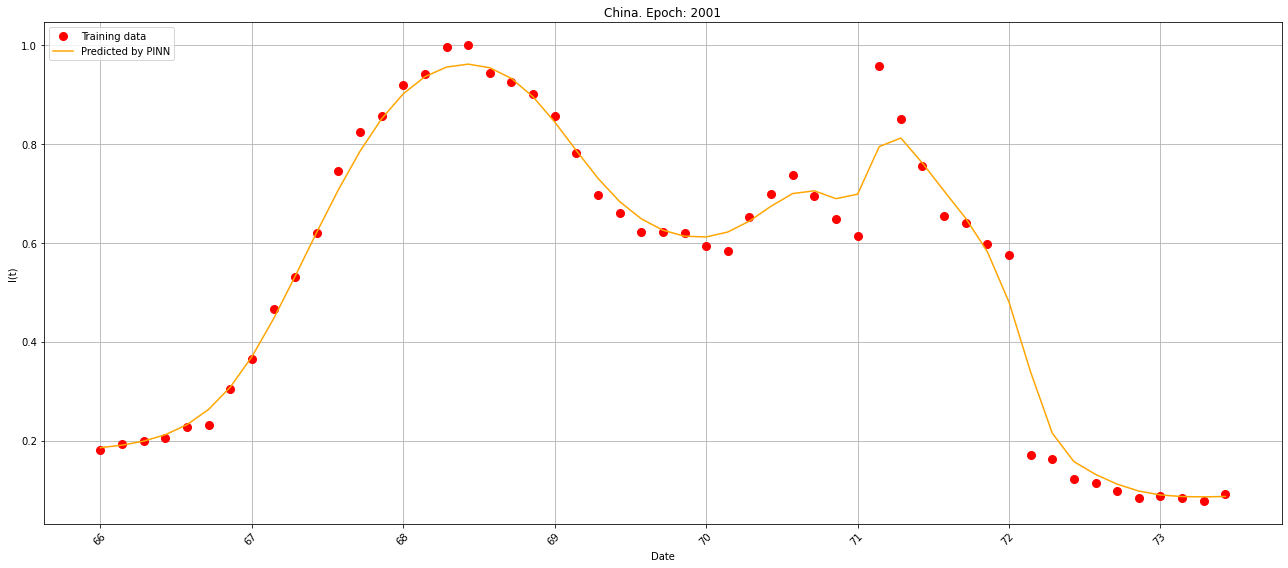

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 2101, MSE Loss = 0.0017596922116354108, SIR Loss = 0.00278218905441463, Total Loss = 0.0045418813824653625
Epoch 2201, MSE Loss = 0.0017192395171150565, SIR Loss = 0.0028020262252539396, Total Loss = 0.004521265625953674
Epoch 2301, MSE Loss = 0.0016844175988808274, SIR Loss = 0.002819811226800084, Total Loss = 0.004504228942096233
Epoch 2401, MSE Loss = 0.0016551361186429858, SIR Loss = 0.0028352641966193914, Total Loss = 0.0044904001988470554
Epoch 2501, MSE Loss = 0.0016311786603182554, SIR Loss = 0.0028484025970101357, Total Loss = 0.004479581490159035
Epoch 2601, MSE Loss = 0.0016117636114358902, SIR Loss = 0.0028593228198587894, Total Loss = 0.00447108643129468
Epoch 2701, MSE Loss = 0.0015963810728862882, SIR Loss = 0.0028682691045105457, Total Loss = 0.004464650060981512
Epoch 2801, MSE Loss = 0.0015843359287828207, SIR Loss = 0.0028754782397300005, Total Loss = 0.004459814168512821
Early stopping at epoch 2828.
Epoch 1, MSE Loss = 0.12351749837398529, SIR Loss = 3.277969

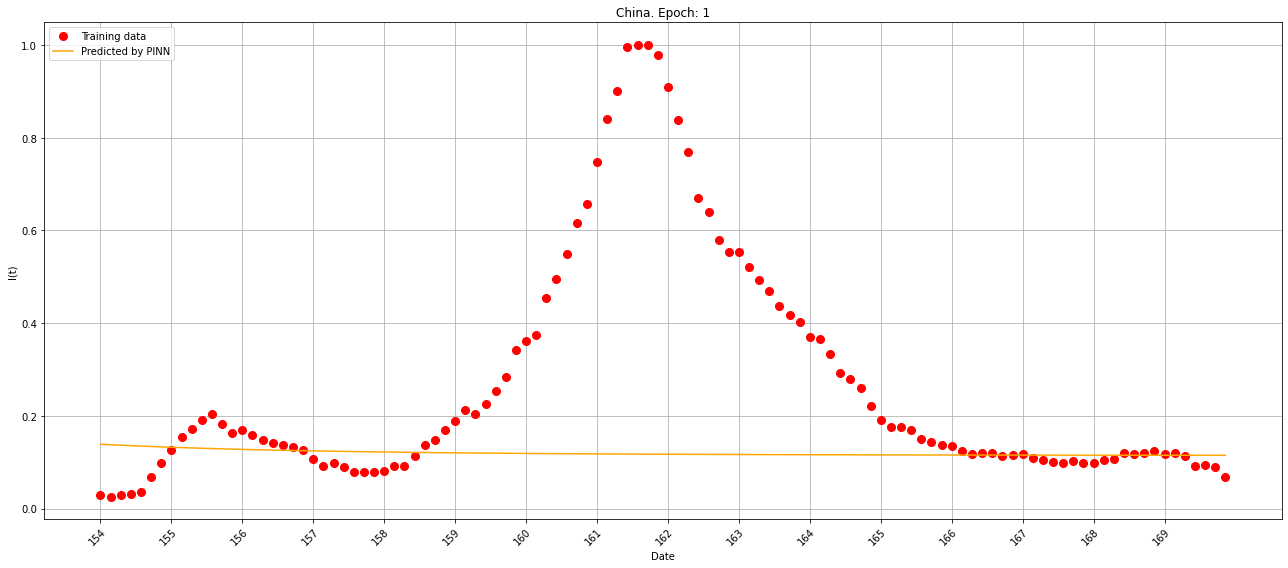

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.06288480013608932, SIR Loss = 9.504631109935602e-11, Total Loss = 0.06288480013608932
Epoch 201, MSE Loss = 0.06285843253135681, SIR Loss = 4.746947834810555e-10, Total Loss = 0.06285843253135681
Epoch 301, MSE Loss = 0.06088166683912277, SIR Loss = 8.48481613502372e-06, Total Loss = 0.06089015305042267
Epoch 401, MSE Loss = 0.005675615277141333, SIR Loss = 0.0002950919442810118, Total Loss = 0.0059707071632146835
Epoch 501, MSE Loss = 0.0020959782414138317, SIR Loss = 0.0005633723922073841, Total Loss = 0.002659350633621216
Epoch 601, MSE Loss = 0.0005758214392699301, SIR Loss = 0.0006086853099986911, Total Loss = 0.0011845068074762821
Epoch 701, MSE Loss = 0.0009451150544919074, SIR Loss = 0.0006242740782909095, Total Loss = 0.0015693891327828169
Epoch 801, MSE Loss = 0.0006804269505664706, SIR Loss = 0.0006438533891923726, Total Loss = 0.001324280397966504
Epoch 901, MSE Loss = 0.0003571310080587864, SIR Loss = 0.0006557477754540741, Total Loss = 0.0010128787

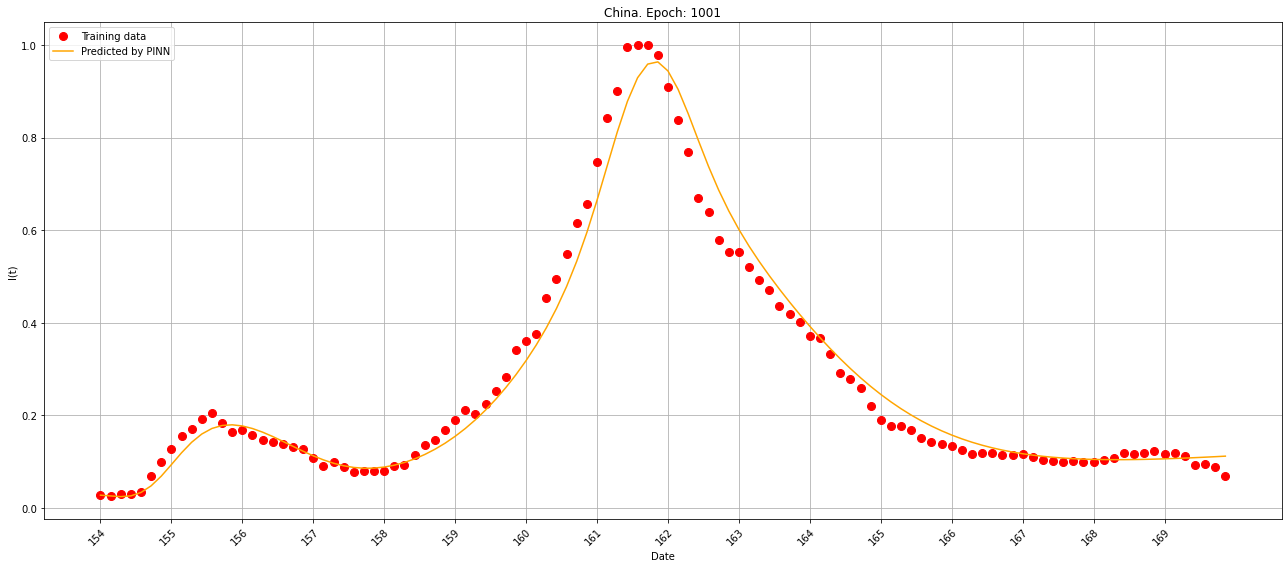

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.00028925100923515856, SIR Loss = 0.000661637051962316, Total Loss = 0.0009508880320936441
Epoch 1201, MSE Loss = 0.0005449785967357457, SIR Loss = 0.00067899189889431, Total Loss = 0.0012239704374223948
Epoch 1301, MSE Loss = 0.0008937245584093034, SIR Loss = 0.0006853147642686963, Total Loss = 0.0015790392644703388
Epoch 1401, MSE Loss = 0.0014129217015579343, SIR Loss = 0.0006747246952727437, Total Loss = 0.002087646396830678
Epoch 1501, MSE Loss = 0.00020833344024140388, SIR Loss = 0.0006766935111954808, Total Loss = 0.0008850269368849695
Epoch 1601, MSE Loss = 0.0018098308937624097, SIR Loss = 0.0006771486951038241, Total Loss = 0.002486979588866234
Epoch 1701, MSE Loss = 0.0014234522823244333, SIR Loss = 0.0006800309638492763, Total Loss = 0.0021034833043813705
Epoch 1801, MSE Loss = 0.00017919718811754137, SIR Loss = 0.0006886565242893994, Total Loss = 0.0008678536978550255
Epoch 1901, MSE Loss = 0.0003271125606261194, SIR Loss = 0.0006952438270673156, To

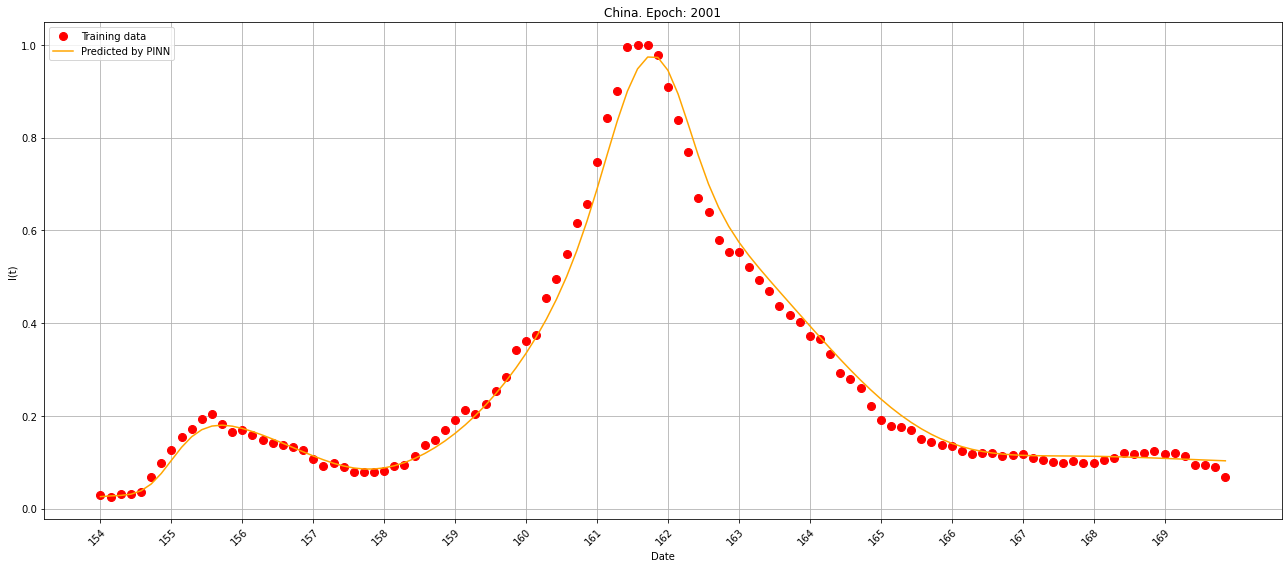

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 2101, MSE Loss = 0.0008028452866710722, SIR Loss = 0.0006881993031129241, Total Loss = 0.0014910446479916573
Epoch 2201, MSE Loss = 0.00017531527555547655, SIR Loss = 0.0006903224857524037, Total Loss = 0.0008656377904117107
Epoch 2301, MSE Loss = 0.000327408779412508, SIR Loss = 0.0006990914116613567, Total Loss = 0.0010265002492815256
Epoch 2401, MSE Loss = 0.000881606712937355, SIR Loss = 0.0006919247098267078, Total Loss = 0.0015735314227640629
Epoch 2501, MSE Loss = 0.00029897186323069036, SIR Loss = 0.0006871231598779559, Total Loss = 0.0009860950522124767
Epoch 2601, MSE Loss = 0.0002586405607871711, SIR Loss = 0.0007018527248874307, Total Loss = 0.0009604932856746018
Epoch 2701, MSE Loss = 0.0008655058918520808, SIR Loss = 0.000698291405569762, Total Loss = 0.001563797239214182
Epoch 2801, MSE Loss = 0.0002022983244387433, SIR Loss = 0.0006917519494891167, Total Loss = 0.0008940502884797752
Epoch 2901, MSE Loss = 0.0003963321796618402, SIR Loss = 0.0007020080229267478, To

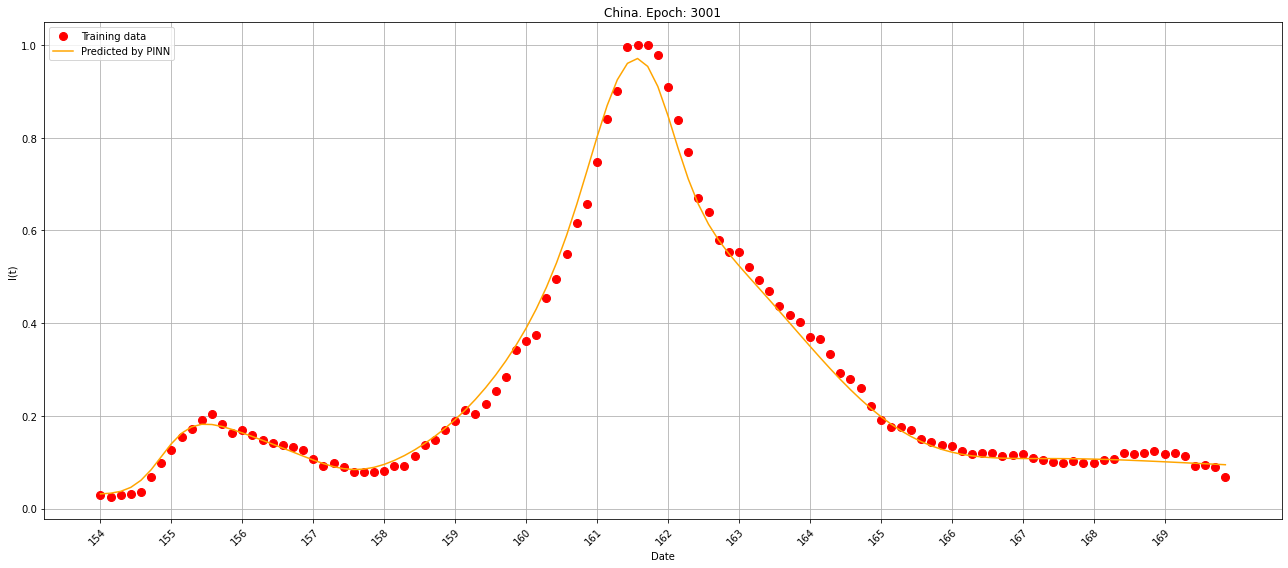

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 3101, MSE Loss = 0.00023686936765443534, SIR Loss = 0.0007027257233858109, Total Loss = 0.0009395951055921614
Epoch 3201, MSE Loss = 0.0008250583778135478, SIR Loss = 0.0006984890205785632, Total Loss = 0.0015235473401844501
Epoch 3301, MSE Loss = 0.0001579631061758846, SIR Loss = 0.0006990850670263171, Total Loss = 0.0008570482023060322
Epoch 3401, MSE Loss = 0.0003871861263178289, SIR Loss = 0.0007003042846918106, Total Loss = 0.0010874904692173004
Epoch 3501, MSE Loss = 0.0007316789706237614, SIR Loss = 0.0006901980377733707, Total Loss = 0.0014218769501894712
Epoch 3601, MSE Loss = 0.0001581149554112926, SIR Loss = 0.0006988526438362896, Total Loss = 0.000856967584695667
Epoch 3701, MSE Loss = 0.000804611889179796, SIR Loss = 0.0007028062827885151, Total Loss = 0.001507418230175972
Epoch 3801, MSE Loss = 0.0004161165270488709, SIR Loss = 0.0006868964992463589, Total Loss = 0.0011030130553990602
Epoch 3901, MSE Loss = 0.0003199764178134501, SIR Loss = 0.0007041082135401666, To

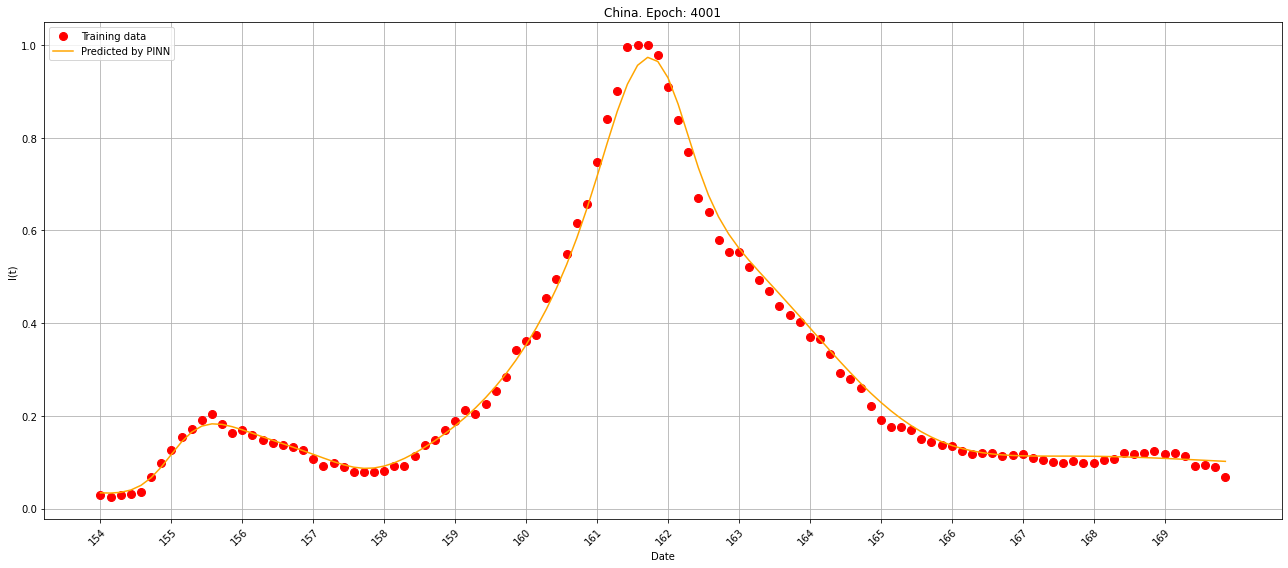

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 4101, MSE Loss = 0.0006814455846324563, SIR Loss = 0.0006971135153435171, Total Loss = 0.0013785590417683125
Epoch 4201, MSE Loss = 0.00020835657778661698, SIR Loss = 0.0006926036439836025, Total Loss = 0.0009009602363221347
Epoch 4301, MSE Loss = 0.0006876341649331152, SIR Loss = 0.0007006147061474621, Total Loss = 0.0013882488710805774
Epoch 4401, MSE Loss = 0.00020912579202558845, SIR Loss = 0.0007072146399877965, Total Loss = 0.0009163404465653002
Epoch 4501, MSE Loss = 0.00014762452337890863, SIR Loss = 0.0007067482802085578, Total Loss = 0.0008543728035874665
Epoch 4601, MSE Loss = 0.0007593731279484928, SIR Loss = 0.0007026645471341908, Total Loss = 0.0014620376750826836
Epoch 4701, MSE Loss = 0.0004610966716427356, SIR Loss = 0.0007012557471171021, Total Loss = 0.0011623523896560073
Epoch 4801, MSE Loss = 0.0007740343571640551, SIR Loss = 0.0007004482904449105, Total Loss = 0.0014744827058166265
Epoch 4901, MSE Loss = 0.00024523402680642903, SIR Loss = 0.00069017137866467

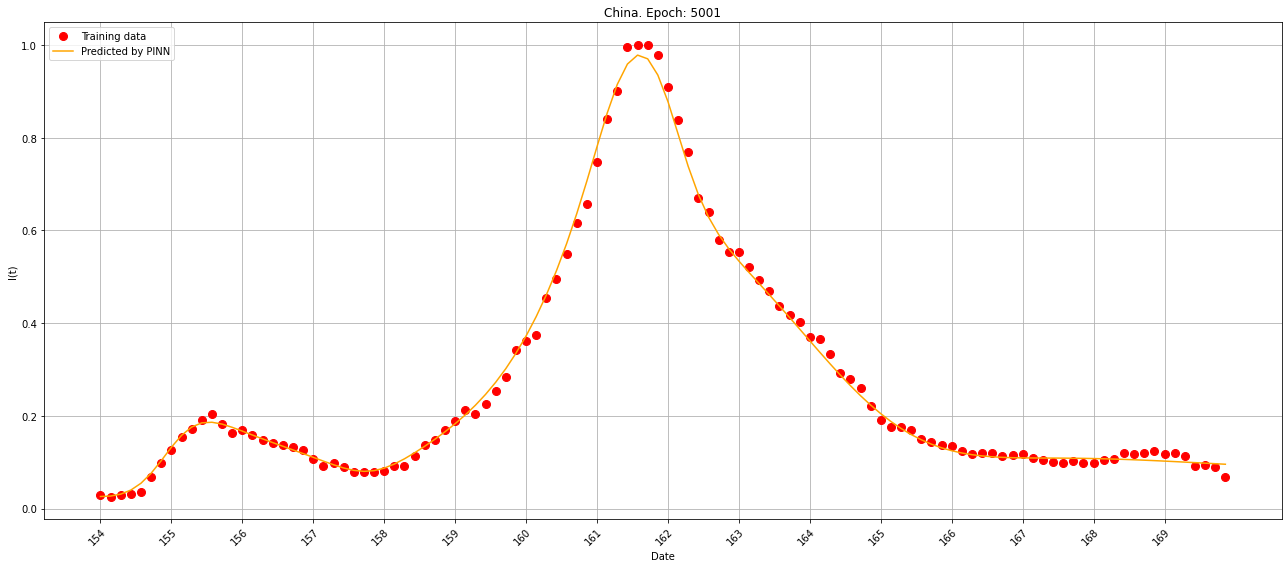

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 5101, MSE Loss = 0.0007299895514734089, SIR Loss = 0.0007002546335570514, Total Loss = 0.0014302441850304604
Epoch 5201, MSE Loss = 0.00017695532005745918, SIR Loss = 0.0006943884072825313, Total Loss = 0.0008713437127880752
Epoch 5301, MSE Loss = 0.0005728112882934511, SIR Loss = 0.0007039253832772374, Total Loss = 0.0012767366133630276
Epoch 5401, MSE Loss = 0.00023036390484776348, SIR Loss = 0.0006929681985639036, Total Loss = 0.0009233321179635823
Epoch 5501, MSE Loss = 0.0004545491829048842, SIR Loss = 0.0007125668344087899, Total Loss = 0.0011671159882098436
Epoch 5601, MSE Loss = 0.000295835779979825, SIR Loss = 0.0006887829513289034, Total Loss = 0.0009846186731010675
Epoch 5701, MSE Loss = 0.00038526675780303776, SIR Loss = 0.0007085431134328246, Total Loss = 0.001093809842132032
Epoch 5801, MSE Loss = 0.0006992904236540198, SIR Loss = 0.0006945583154447377, Total Loss = 0.0013938487973064184
Epoch 5901, MSE Loss = 0.00014607407501898706, SIR Loss = 0.0007097733905538917

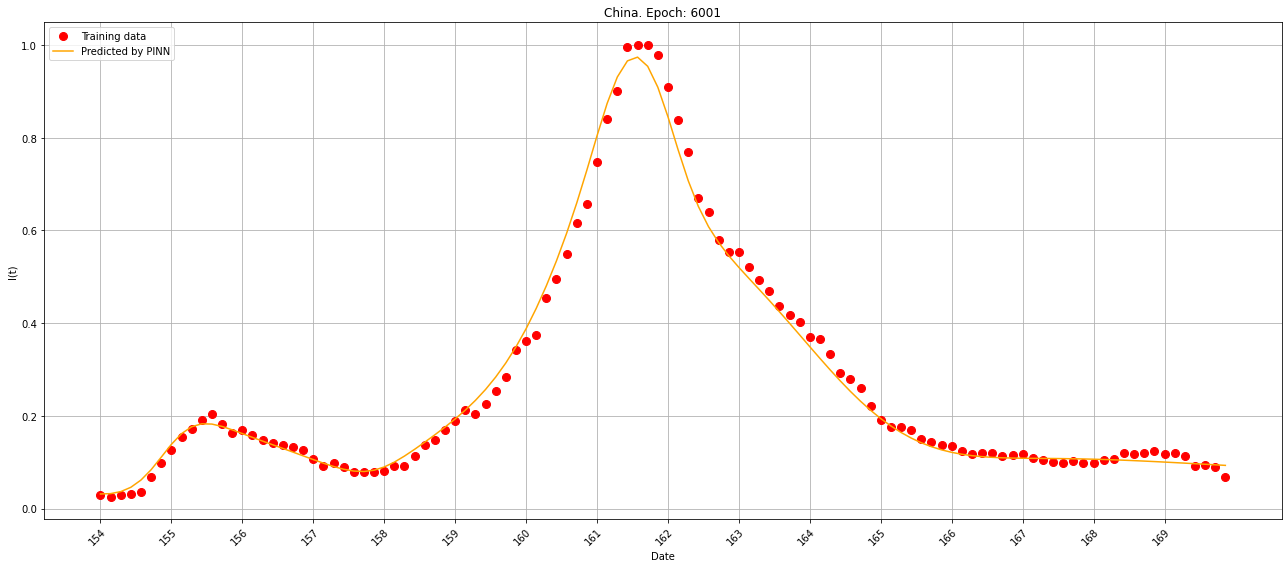

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 6101, MSE Loss = 0.000426813232479617, SIR Loss = 0.000695162802003324, Total Loss = 0.0011219760635867715
Epoch 6201, MSE Loss = 0.0001602018455741927, SIR Loss = 0.0007024677470326424, Total Loss = 0.0008626696071587503
Epoch 6301, MSE Loss = 0.00016427157970611006, SIR Loss = 0.0007138283108361065, Total Loss = 0.0008780998759903014
Epoch 6401, MSE Loss = 0.00045502945431508124, SIR Loss = 0.0007061302312649786, Total Loss = 0.0011611597146838903
Epoch 6501, MSE Loss = 0.0007716297404840589, SIR Loss = 0.0006928229704499245, Total Loss = 0.0014644527109339833
Epoch 6601, MSE Loss = 0.0007297266274690628, SIR Loss = 0.0007058771443553269, Total Loss = 0.0014356037136167288
Epoch 6701, MSE Loss = 0.00045585143379867077, SIR Loss = 0.0006916081765666604, Total Loss = 0.0011474596103653312
Epoch 6801, MSE Loss = 0.0005591171211563051, SIR Loss = 0.0007052171276882291, Total Loss = 0.0012643341906368732
Epoch 6901, MSE Loss = 0.00034597530611790717, SIR Loss = 0.0006838403642177582

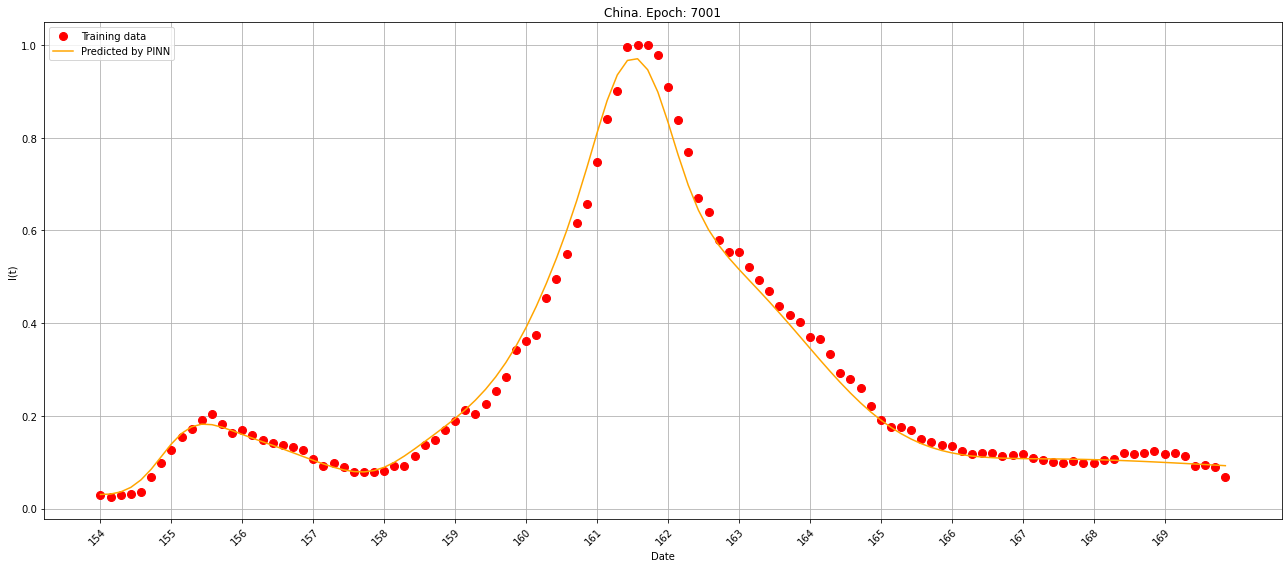

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 7101, MSE Loss = 0.00027095762197859585, SIR Loss = 0.00070032017538324, Total Loss = 0.0009712778264656663
Epoch 7201, MSE Loss = 0.00027672608848661184, SIR Loss = 0.0007059639319777489, Total Loss = 0.0009826900204643607
Epoch 7301, MSE Loss = 0.00027925337781198323, SIR Loss = 0.0007088244310580194, Total Loss = 0.000988077837973833
Epoch 7401, MSE Loss = 0.00033726025139912963, SIR Loss = 0.0007084766984917223, Total Loss = 0.001045736949890852
Epoch 7501, MSE Loss = 0.0006399372941814363, SIR Loss = 0.0006915529374964535, Total Loss = 0.0013314902316778898
Epoch 7601, MSE Loss = 0.0004556838539429009, SIR Loss = 0.0007104788674041629, Total Loss = 0.0011661627795547247
Epoch 7701, MSE Loss = 0.00020689770462922752, SIR Loss = 0.0007001619087532163, Total Loss = 0.0009070596424862742
Epoch 7801, MSE Loss = 0.00044639682164415717, SIR Loss = 0.0007173228077590466, Total Loss = 0.0011637196876108646
Epoch 7901, MSE Loss = 0.0007359178853221238, SIR Loss = 0.0006947649526409805

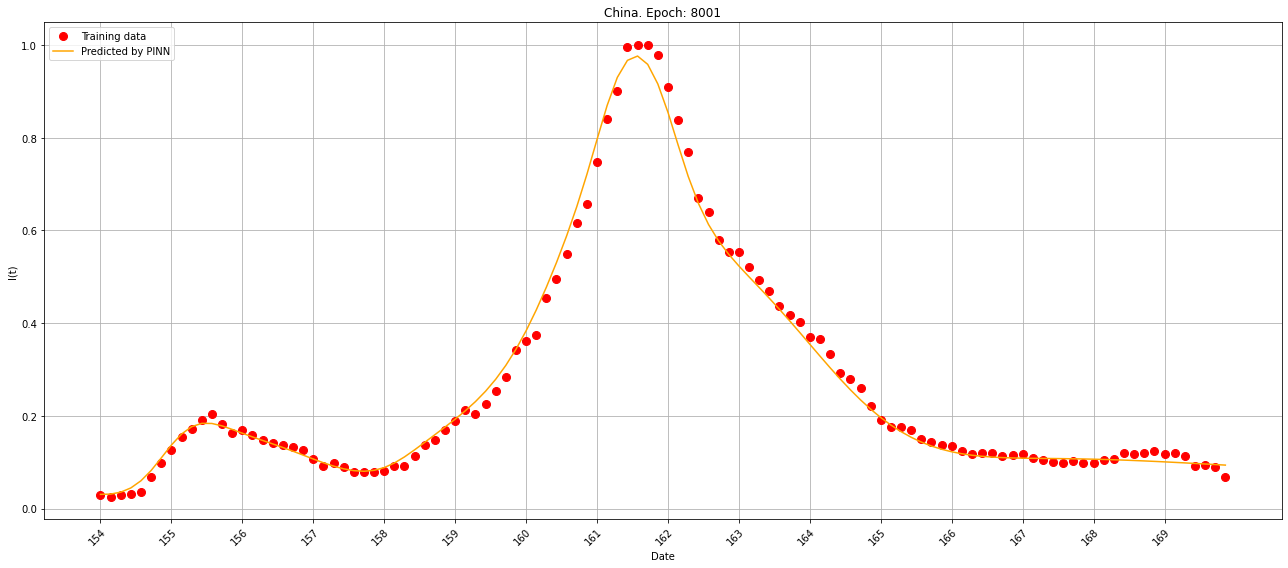

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 8101, MSE Loss = 0.0007711433572694659, SIR Loss = 0.0006906616617925465, Total Loss = 0.0014618050772696733
Epoch 8201, MSE Loss = 0.0006459555006586015, SIR Loss = 0.0007015184382908046, Total Loss = 0.0013474739389494061
Epoch 8301, MSE Loss = 0.0001875184680102393, SIR Loss = 0.0007087442209012806, Total Loss = 0.0008962627034634352
Epoch 8401, MSE Loss = 0.0009196574683301151, SIR Loss = 0.0006975693977437913, Total Loss = 0.0016172268660739064
Epoch 8501, MSE Loss = 0.0002151721710106358, SIR Loss = 0.0007109277066774666, Total Loss = 0.0009260998922400177
Epoch 8601, MSE Loss = 0.0006109781679697335, SIR Loss = 0.0006980178295634687, Total Loss = 0.0013089959975332022
Epoch 8701, MSE Loss = 0.0005257147131487727, SIR Loss = 0.0006930626113899052, Total Loss = 0.0012187773827463388
Epoch 8801, MSE Loss = 0.0006557490560226142, SIR Loss = 0.0006922064931131899, Total Loss = 0.0013479555491358042
Epoch 8901, MSE Loss = 0.00015659294149372727, SIR Loss = 0.000714621099177748, 

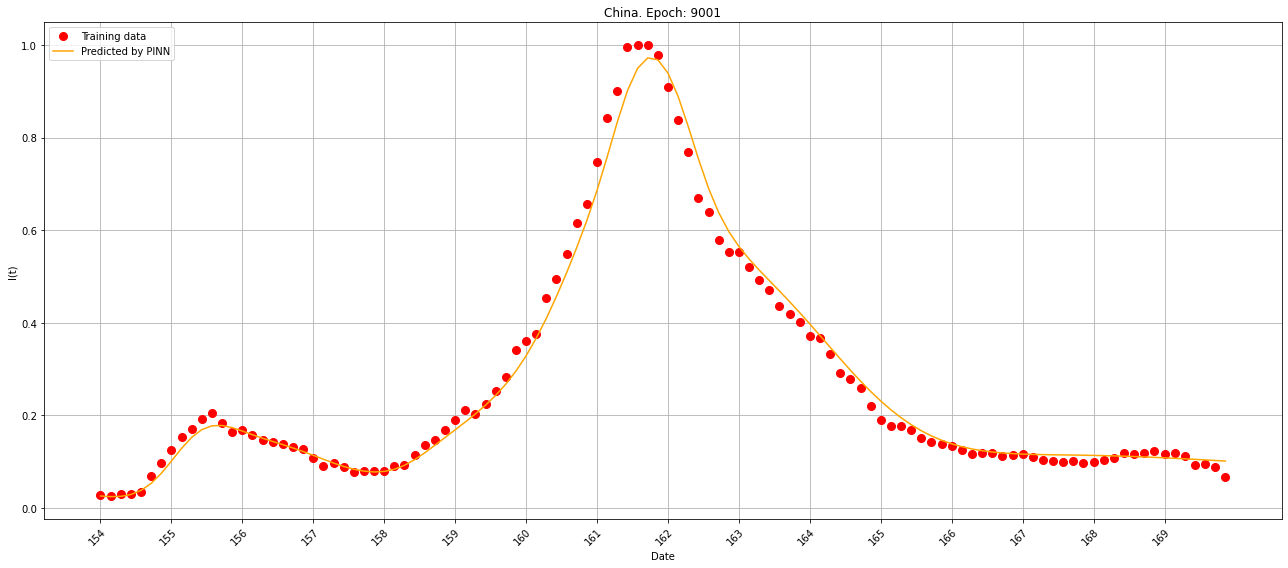

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 9101, MSE Loss = 0.00015853320655878633, SIR Loss = 0.0006914228433743119, Total Loss = 0.0008499560644850135
Epoch 9201, MSE Loss = 0.0003317344526294619, SIR Loss = 0.0007031228742562234, Total Loss = 0.0010348573559895158
Epoch 9301, MSE Loss = 0.0002924776345025748, SIR Loss = 0.0007116050110198557, Total Loss = 0.0010040826164186
Epoch 9401, MSE Loss = 0.00013453415886033326, SIR Loss = 0.0007078686030581594, Total Loss = 0.0008424027473665774
Epoch 9501, MSE Loss = 0.0002536100510042161, SIR Loss = 0.0006985223153606057, Total Loss = 0.0009521323954686522
Epoch 9601, MSE Loss = 0.00013283293810673058, SIR Loss = 0.0007108720019459724, Total Loss = 0.0008437049109488726
Epoch 9701, MSE Loss = 0.00022402066679205745, SIR Loss = 0.0007107100100256503, Total Loss = 0.0009347306913696229
Epoch 9801, MSE Loss = 0.0002564441820140928, SIR Loss = 0.0007039388292469084, Total Loss = 0.0009603829821571708
Epoch 9901, MSE Loss = 0.00020348156976979226, SIR Loss = 0.0006932180258445442

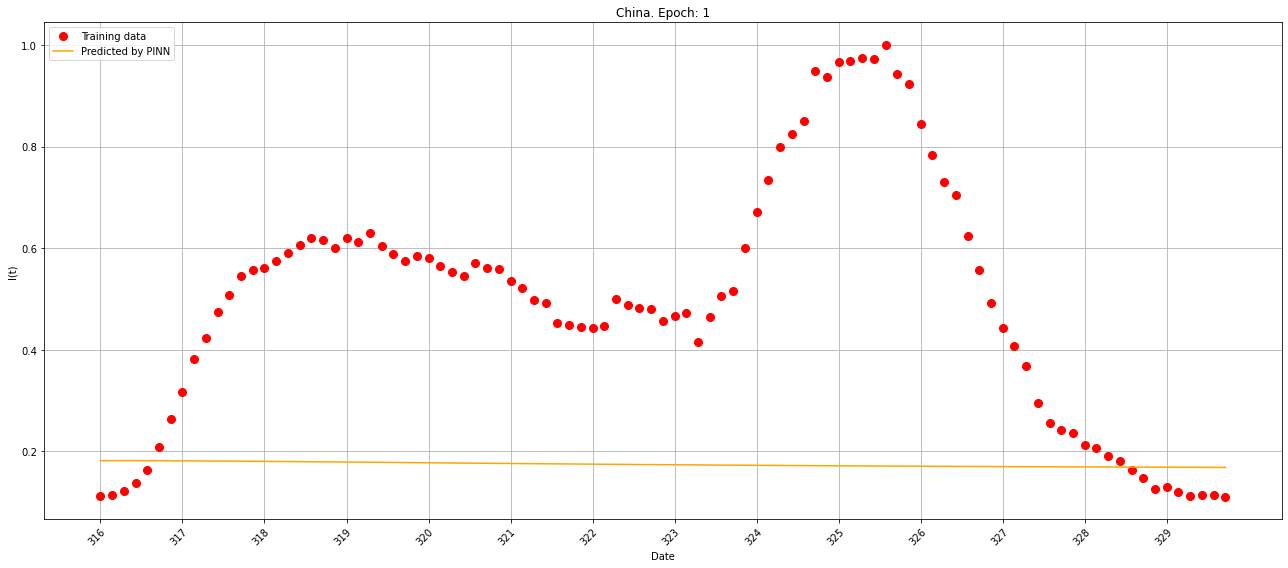

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.057816032320261, SIR Loss = 6.5262344139949136e-12, Total Loss = 0.057816032320261
Epoch 201, MSE Loss = 0.05781262367963791, SIR Loss = 3.640657220138621e-12, Total Loss = 0.05781262367963791
Epoch 301, MSE Loss = 0.05779064819216728, SIR Loss = 9.61475787875088e-10, Total Loss = 0.05779064819216728
Epoch 401, MSE Loss = 0.0577729269862175, SIR Loss = 2.9284681346553043e-09, Total Loss = 0.0577729307115078
Epoch 501, MSE Loss = 0.05773979425430298, SIR Loss = 9.317196791869264e-09, Total Loss = 0.057739805430173874
Epoch 601, MSE Loss = 0.058691252022981644, SIR Loss = 6.675271880390854e-12, Total Loss = 0.058691252022981644
Epoch 701, MSE Loss = 0.05780757963657379, SIR Loss = 2.113596840949694e-12, Total Loss = 0.05780757963657379
Epoch 801, MSE Loss = 0.05780728906393051, SIR Loss = 1.882423253732335e-12, Total Loss = 0.05780728906393051
Epoch 901, MSE Loss = 0.05780699849128723, SIR Loss = 2.4908939928042217e-12, Total Loss = 0.05780699849128723
Epoch 1001,

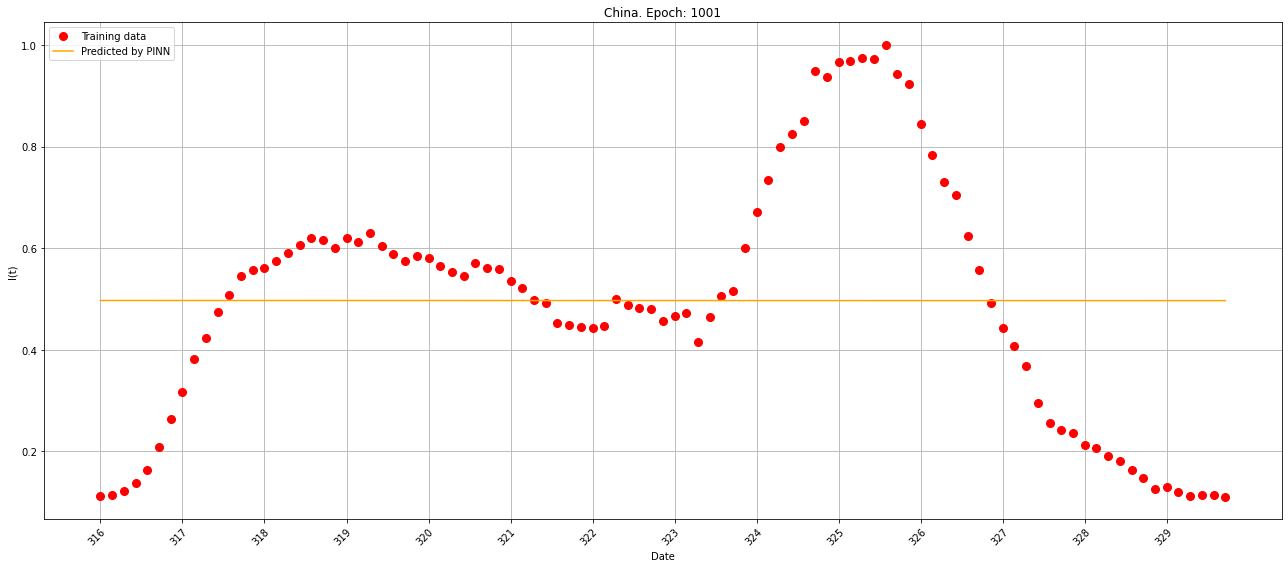

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.057799212634563446, SIR Loss = 6.819158432369576e-11, Total Loss = 0.057799212634563446
Epoch 1201, MSE Loss = 0.057596370577812195, SIR Loss = 3.7643197003944806e-08, Total Loss = 0.05759640783071518
Epoch 1301, MSE Loss = 0.057807695120573044, SIR Loss = 9.017299981792931e-14, Total Loss = 0.057807695120573044
Epoch 1401, MSE Loss = 0.05780647695064545, SIR Loss = 7.428880102224034e-14, Total Loss = 0.05780647695064545
Epoch 1501, MSE Loss = 0.05780642479658127, SIR Loss = 6.1739845278342e-14, Total Loss = 0.05780642479658127
Early stopping at epoch 1587.
Epoch 1, MSE Loss = 0.11076302826404572, SIR Loss = 0.0, Total Loss = 0.11076302826404572


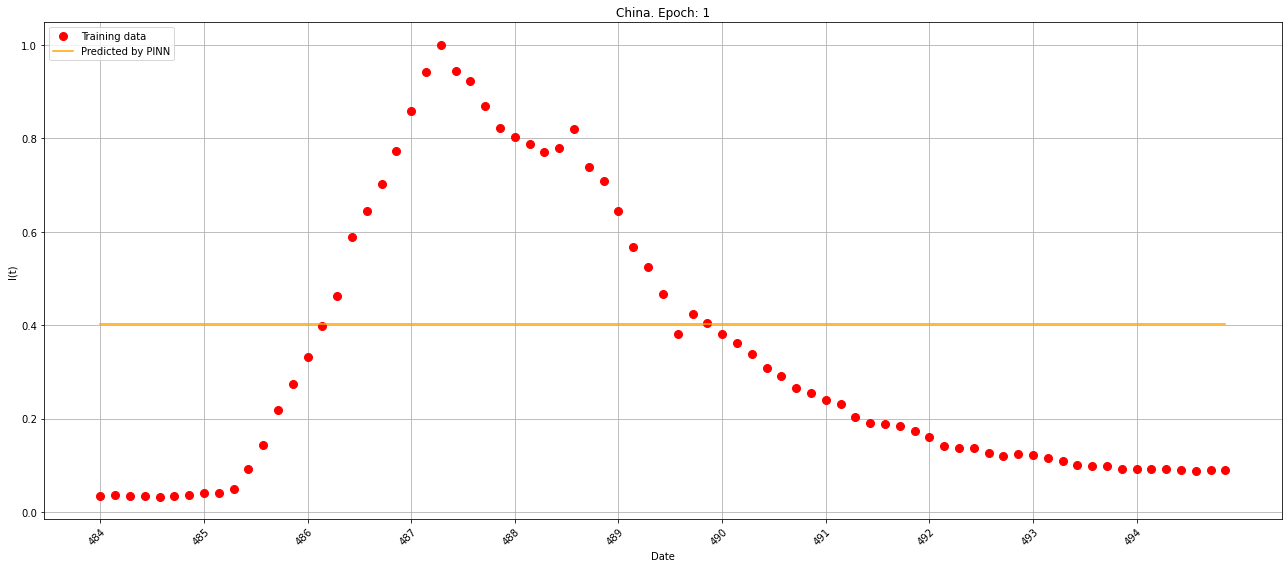

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.08588895201683044, SIR Loss = 0.0, Total Loss = 0.08588895201683044
Epoch 201, MSE Loss = 0.08588869869709015, SIR Loss = 0.0, Total Loss = 0.08588869869709015
Epoch 301, MSE Loss = 0.08588869124650955, SIR Loss = 0.0, Total Loss = 0.08588869124650955
Epoch 401, MSE Loss = 0.08588869124650955, SIR Loss = 0.0, Total Loss = 0.08588869124650955
Epoch 501, MSE Loss = 0.08588868379592896, SIR Loss = 0.0, Total Loss = 0.08588868379592896
Epoch 601, MSE Loss = 0.08588868379592896, SIR Loss = 0.0, Total Loss = 0.08588868379592896
Epoch 701, MSE Loss = 0.08588868379592896, SIR Loss = 0.0, Total Loss = 0.08588868379592896
Epoch 801, MSE Loss = 0.08588869124650955, SIR Loss = 0.0, Total Loss = 0.08588869124650955
Epoch 901, MSE Loss = 0.08588868379592896, SIR Loss = 0.0, Total Loss = 0.08588868379592896
Epoch 1001, MSE Loss = 0.08588868379592896, SIR Loss = 0.0, Total Loss = 0.08588868379592896


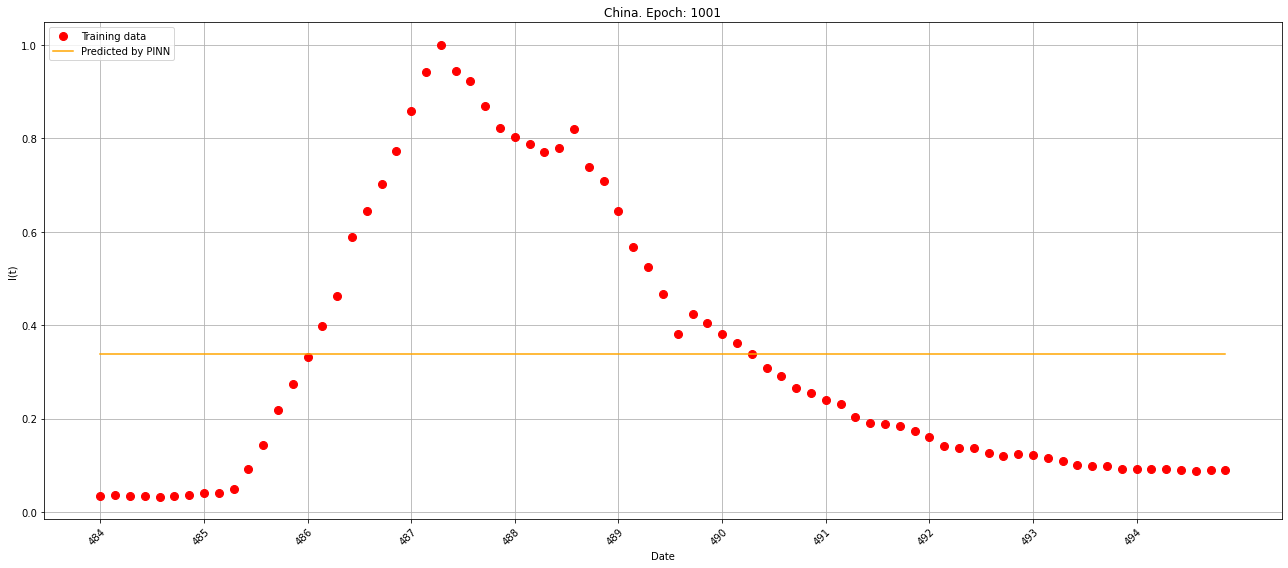

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.08588869124650955, SIR Loss = 0.0, Total Loss = 0.08588869124650955
Early stopping at epoch 1110.
Epoch 1, MSE Loss = 0.10795193165540695, SIR Loss = 0.0, Total Loss = 0.10795193165540695


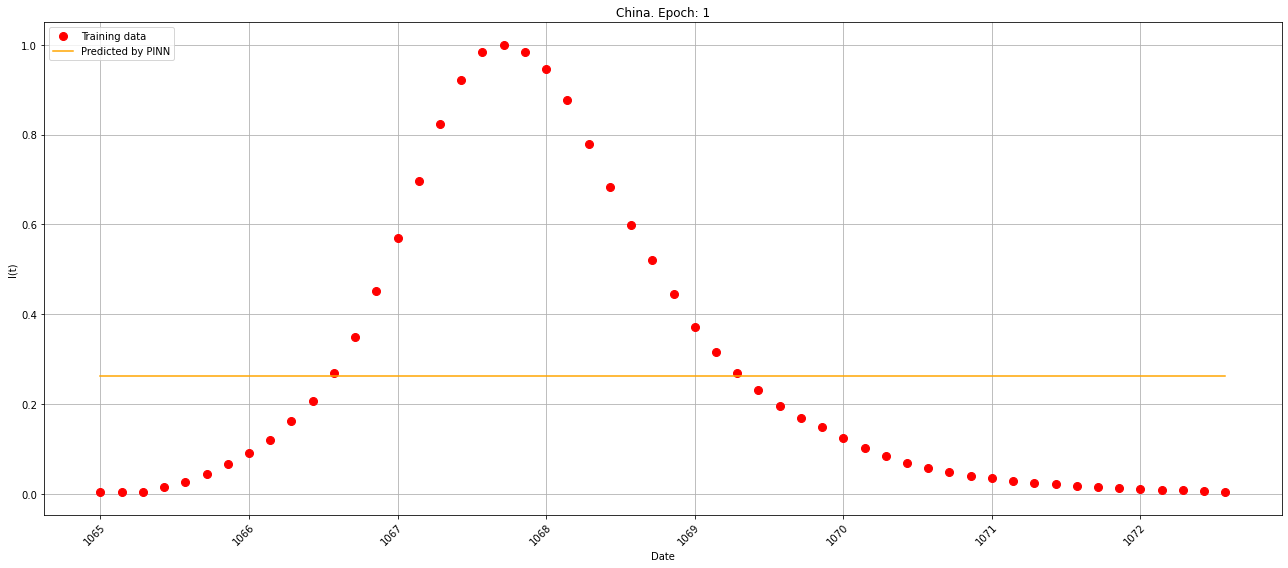

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 101, MSE Loss = 0.1043490469455719, SIR Loss = 0.0, Total Loss = 0.1043490469455719
Epoch 201, MSE Loss = 0.10434898734092712, SIR Loss = 0.0, Total Loss = 0.10434898734092712
Epoch 301, MSE Loss = 0.10434897989034653, SIR Loss = 0.0, Total Loss = 0.10434897989034653
Epoch 401, MSE Loss = 0.10434897989034653, SIR Loss = 0.0, Total Loss = 0.10434897989034653
Epoch 501, MSE Loss = 0.10434897989034653, SIR Loss = 0.0, Total Loss = 0.10434897989034653
Epoch 601, MSE Loss = 0.10434897989034653, SIR Loss = 0.0, Total Loss = 0.10434897989034653
Epoch 701, MSE Loss = 0.10434897989034653, SIR Loss = 0.0, Total Loss = 0.10434897989034653
Epoch 801, MSE Loss = 0.10434897989034653, SIR Loss = 0.0, Total Loss = 0.10434897989034653
Epoch 901, MSE Loss = 0.10434898734092712, SIR Loss = 0.0, Total Loss = 0.10434898734092712
Epoch 1001, MSE Loss = 0.10434897989034653, SIR Loss = 0.0, Total Loss = 0.10434897989034653


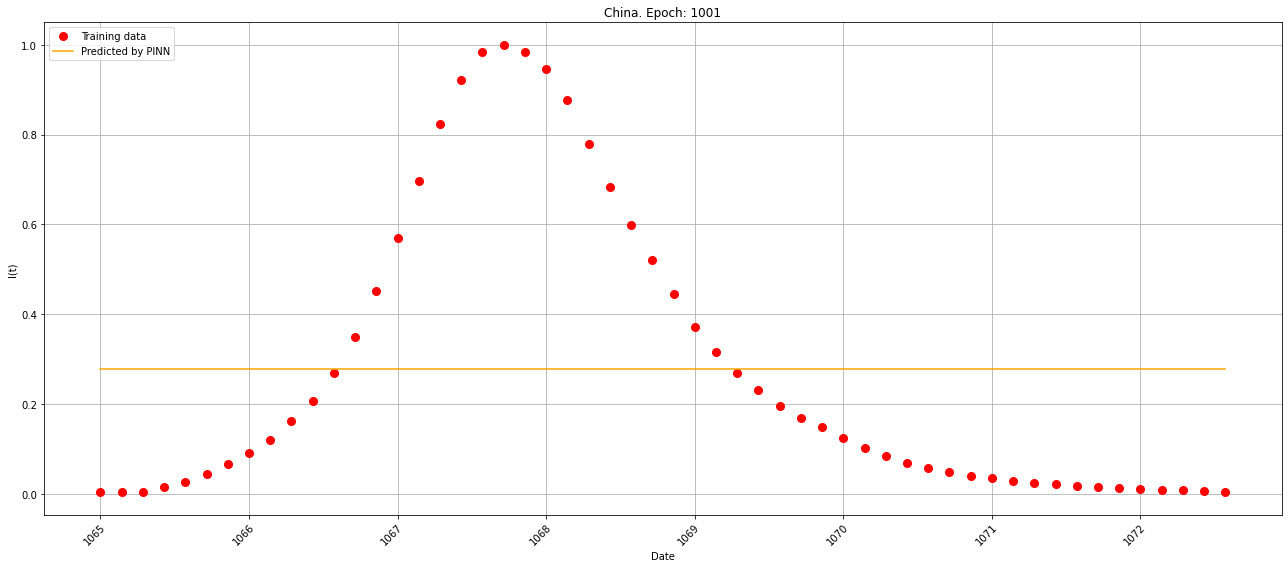

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_15184\154151033.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


Epoch 1101, MSE Loss = 0.10434897989034653, SIR Loss = 0.0, Total Loss = 0.10434897989034653
Early stopping at epoch 1123.


In [87]:
model = PINN()

for country in training_coutries:
    for wave in data[country]:
        t_data = torch.tensor(time_data[country][wave], dtype=torch.float32).view(-1, 1)
        y_data = torch.tensor(data[country][wave], dtype=torch.float32).view(-1, 1)

        t_train = t_data
        y_train = y_data / max(y_data)

        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        losses = train(model, optimizer, t_data, y_data, t_train, y_train, sigma, sigma0, mu, epochs=10000, patience=1000, display_step=1000, date_ticks=time_data[country][wave], country=country)

        # Save the model
        torch.save(model.state_dict(), f"models/{country}_wave_{wave}.pt")